In [28]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import cgm_interpretability_extension as cie
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

In [10]:
df = pd.read_csv('df_metrics_CGM_biochem_demographics.csv')

# Display basic info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

DataFrame shape: (736, 65)
Columns: ['Patient_ID', 'TIR_Q1', 'TIR_Q2', 'TIR_Q3', 'TIR_Q4', 'TBR_Q1', 'TBR_Q2', 'TBR_Q3', 'TBR_Q4', 'CV_Q1', 'CV_Q2', 'CV_Q3', 'CV_Q4', 'slope_TIR_per_day', 'slope_mean_glucose_per_day', 'glucose_p10', 'glucose_p25', 'glucose_p50', 'glucose_p75', 'glucose_p90', 'rolling_mean_std', 'rolling_cv_std', 'MAGE', 'MODD', 'CONGA_4', 'hypo_count', 'hyper_count', 'avg_hypo_duration', 'avg_hyper_duration', 'TIR_day', 'TIR_night', 'TBR_day', 'TBR_night', 'CV_day', 'CV_night', 'rapid_spike_count', 'slope_CV_interaction', 'A1c_mean', 'A1c_SD', 'Sex', 'Number_of_days_with_measures', 'Number_of_measurements', 'Number_of_biochemical_parameters', 'Number_of_diagnostics', 'Age', 'Alanine transaminase (GPT)_mean', 'Albumin (urine)_mean', 'Chlorine_mean', 'Creatinine_mean', 'Creatinine (urine)_mean', 'Gamma-glutamyl Transferase (GGT)_mean', 'Glucose_mean', 'HDL cholesterol_mean', 'Potassium_mean', 'Sodium_mean', 'Thyrotropin (TSH)_mean', 'Total cholesterol_mean', 'Triglycerid

In [11]:
print("Class distribution:")
print(df['Hypothyroidism'].value_counts())
print(df['Hypertension'].value_counts()) 
print(df['Retinopathy'].value_counts())
print(df['Lipid metabolism'].value_counts())
print(df['Airway Disease'].value_counts())
print(df['Nephropathy and/or Neuropathy'].value_counts())

Class distribution:
Hypothyroidism
0    639
1     97
Name: count, dtype: int64
Hypertension
0    667
1     69
Name: count, dtype: int64
Retinopathy
0    640
1     96
Name: count, dtype: int64
Lipid metabolism
0    683
1     53
Name: count, dtype: int64
Airway Disease
0    697
1     39
Name: count, dtype: int64
Nephropathy and/or Neuropathy
0    697
1     39
Name: count, dtype: int64


In [12]:
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head())

Missing values per column:
Chlorine_mean            313
Number_of_diagnostics    225
A1c_SD                    30
Uric acid_mean            28
Albumin (urine)_mean      23
dtype: int64


In [13]:
# Create a new dataframe by dropping the high-missingness columns
df_clean = df.drop(columns=['Chlorine_mean', 'Number_of_diagnostics'])

# Keep only complete cases (rows with no missing values)
df_complete = df_clean.dropna()

print(f"Original dataframe shape: {df.shape}")
print(f"After dropping high-missing columns: {df_clean.shape}")
print(f"After keeping only complete cases: {df_complete.shape}")
print(f"Final patient count: {len(df_complete)}")

# Show missing values in the final dataset to verify
print("\nMissing values in final dataset:")
print(df_complete.isnull().sum().sum())  # Should be 0

Original dataframe shape: (736, 65)
After dropping high-missing columns: (736, 63)
After keeping only complete cases: (689, 63)
Final patient count: 689

Missing values in final dataset:
0


In [14]:
patients_with_lipid_issue = df_complete[df_complete['Lipid metabolism'] == 1]['Patient_ID']

patients_list = patients_with_lipid_issue.tolist()

print(patients_list)

['LIB193276', 'LIB193278', 'LIB193302', 'LIB193346', 'LIB193351', 'LIB193352', 'LIB193366', 'LIB193367', 'LIB193372', 'LIB193375', 'LIB193381', 'LIB193395', 'LIB193416', 'LIB193425', 'LIB193426', 'LIB193434', 'LIB193438', 'LIB193441', 'LIB193449', 'LIB193472', 'LIB193476', 'LIB193482', 'LIB193503', 'LIB193535', 'LIB193540', 'LIB193542', 'LIB193553', 'LIB193554', 'LIB193556', 'LIB193557', 'LIB193558', 'LIB193573', 'LIB193580', 'LIB193599', 'LIB193603', 'LIB193610', 'LIB193645', 'LIB193761', 'LIB193776', 'LIB193780', 'LIB193790', 'LIB193794', 'LIB193795', 'LIB193820', 'LIB193824', 'LIB193837', 'LIB193902', 'LIB193980', 'LIB194015', 'LIB194019', 'LIB194062', 'LIB194161']


In [15]:
# -----------------------------
# 1. Choose representative conditions
# -----------------------------
tune_conditions = ['Retinopathy', 'Airway Disease', 'Nephropathy and/or Neuropathy']

# Combine patients from these conditions
df_tune = pd.concat([df_complete[df_complete[cond]==1] for cond in tune_conditions], axis=0)
df_tune = df_tune.drop_duplicates(subset='Patient_ID')  # avoid duplicates if patient has multiple conditions

# -----------------------------
# 2. One-hot encode Sex
# -----------------------------
if 'Sex' in df_tune.columns:
    df_tune = pd.get_dummies(df_tune, columns=['Sex'], drop_first=True)

# -----------------------------
# 3. Define target and features
# -----------------------------
target_col = 'Retinopathy'  # placeholder for tuning
condition_cols = ['Hypothyroidism','Hypertension','Retinopathy','Lipid metabolism',
                  'Airway Disease','Nephropathy and/or Neuropathy']
cols_to_remove = ['Patient_ID'] + [c for c in condition_cols if c != target_col]

# CGM metrics
cgm_metrics = [
    "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4","TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
    "CV_Q1","CV_Q2","CV_Q3","CV_Q4","slope_TIR_per_day","slope_mean_glucose_per_day",
    "glucose_p10","glucose_p25","glucose_p50","glucose_p75","glucose_p90",
    "rolling_mean_std","rolling_cv_std","MAGE","MODD","CONGA_4","hypo_count",
    "hyper_count","avg_hypo_duration","avg_hyper_duration","TIR_day","TIR_night",
    "TBR_day","TBR_night","CV_day","CV_night","rapid_spike_count","slope_CV_interaction"
]

X = df_tune.drop(columns=cols_to_remove + [target_col], errors='ignore')
y = df_tune[target_col]

# -----------------------------
# 4. One-hot encode any remaining categorical columns
# -----------------------------
cat_cols = X.select_dtypes(include=['object','category']).columns
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# -----------------------------
# 5. Standardize
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 6. Apply SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# -----------------------------
# 7. Define parameter grid
# -----------------------------
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# -----------------------------
# 8. GridSearchCV
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_res, y_res)

# -----------------------------
# 9. Best hyperparameters
# -----------------------------
print("Best hyperparameters:", grid.best_params_)


Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


In [16]:
def run_cross_validation_xgboost(df, target_col, cgm_subset=None, n_splits=10, random_state=42):
    """
    Cross-validation using XGBoost for three scenarios:
        - with CGM + biochemical
        - without CGM (biochemical only)
        - only CGM
    
    Returns metrics, fitted models, and predictions.
    """

    # One-hot encode Sex
    sex_encoded = False
    if 'Sex' in df.columns:
        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        sex_encoded = True
        sex_column_name = 'Sex_M' if 'Sex_M' in df.columns else next((col for col in df.columns if 'sex' in col.lower()), None)

    # CGM metrics
    cgm_metrics = [
        "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4","TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
        "CV_Q1","CV_Q2","CV_Q3","CV_Q4","slope_TIR_per_day","slope_mean_glucose_per_day",
        "glucose_p10","glucose_p25","glucose_p50","glucose_p75","glucose_p90",
        "rolling_mean_std","rolling_cv_std","MAGE","MODD","CONGA_4","hypo_count",
        "hyper_count","avg_hypo_duration","avg_hyper_duration","TIR_day","TIR_night",
        "TBR_day","TBR_night","CV_day","CV_night","rapid_spike_count","slope_CV_interaction"
    ]

    # Features to exclude
    condition_cols = [
        'Hypothyroidism', 'Hypertension', 'Retinopathy',
        'Lipid metabolism', 'Airway Disease', 'Nephropathy and/or Neuropathy'
    ]
    cols_to_remove = ['Patient_ID'] + [c for c in condition_cols if c != target_col]

    # Get all non-target columns
    all_features = df.drop(columns=cols_to_remove + [target_col], errors='ignore').columns.tolist()
    
    # Identify which columns are CGM vs non-CGM
    non_cgm_features = [col for col in all_features if col not in cgm_metrics]
    
    # Define datasets with explicit feature tracking
    # Baseline: labs + demographics only (no CGM) - includes Sex_M
    X_base = df[non_cgm_features].copy()
    
    # Full or ablated CGM + baseline
    if cgm_subset is None:
        # Full CGM
        X_all = df[all_features].copy()
        X_only_cgm = df[cgm_metrics].copy()
    else:
        # Ablated CGM group
        X_all = df[non_cgm_features + cgm_subset].copy()
        X_only_cgm = df[cgm_subset].copy()
    
    # Explicit biochemical-only baseline (already defined as X_base)
    X_no_cgm = X_base.copy()
    
    # Target
    y = df[target_col]

    # Get column names for each dataset
    all_feature_names = X_all.columns.tolist()
    no_cgm_feature_names = X_no_cgm.columns.tolist()
    only_cgm_feature_names = X_only_cgm.columns.tolist()
    
    # Store scalers for each fold to use later
    scalers = {
        'with_cgm': [],
        'without_cgm': [],
        'only_cgm': []
    }

    # Results dictionary
    results = {
        'with_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': [], 'X_test_scaled': [], 'X_test_raw': []},
        'without_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': [], 'X_test_scaled': [], 'X_test_raw': []},
        'only_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': [], 'X_test_scaled': [], 'X_test_raw': []}
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y), 1):
        # Train/test splits - keep as DataFrames for now
        X_train_all, X_test_all = X_all.iloc[train_idx], X_all.iloc[test_idx]
        X_train_no_cgm, X_test_no_cgm = X_no_cgm.iloc[train_idx], X_no_cgm.iloc[test_idx]
        X_train_only, X_test_only = X_only_cgm.iloc[train_idx], X_only_cgm.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale
        scaler_all = StandardScaler().fit(X_train_all)
        scaler_no_cgm = StandardScaler().fit(X_train_no_cgm)
        scaler_only = StandardScaler().fit(X_train_only)
        
        scalers['with_cgm'].append(scaler_all)
        scalers['without_cgm'].append(scaler_no_cgm)
        scalers['only_cgm'].append(scaler_only)

        X_train_all_scaled = scaler_all.transform(X_train_all)
        X_test_all_scaled = scaler_all.transform(X_test_all)
        X_train_no_cgm_scaled = scaler_no_cgm.transform(X_train_no_cgm)
        X_test_no_cgm_scaled = scaler_no_cgm.transform(X_test_no_cgm)
        X_train_only_scaled = scaler_only.transform(X_train_only)
        X_test_only_scaled = scaler_only.transform(X_test_only)

        # Store raw X_test for SHAP analysis
        results['with_cgm']['X_test_raw'].append(X_test_all)
        results['without_cgm']['X_test_raw'].append(X_test_no_cgm)
        results['only_cgm']['X_test_raw'].append(X_test_only)

        # SMOTE
        smote = SMOTE(random_state=random_state + fold)
        X_train_all_smote, y_train_all_smote = smote.fit_resample(X_train_all_scaled, y_train)
        X_train_no_cgm_smote, y_train_no_cgm_smote = smote.fit_resample(X_train_no_cgm_scaled, y_train)
        X_train_only_smote, y_train_only_smote = smote.fit_resample(X_train_only_scaled, y_train)

        # XGBoost parameters
        model_params = {
            'n_estimators': 500,
            'max_depth': 3,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'use_label_encoder': False,
            'random_state': random_state
        }

        # Fit models
        models = {
            'with_cgm': xgb.XGBClassifier(**model_params).fit(X_train_all_smote, y_train_all_smote),
            'without_cgm': xgb.XGBClassifier(**model_params).fit(X_train_no_cgm_smote, y_train_no_cgm_smote),
            'only_cgm': xgb.XGBClassifier(**model_params).fit(X_train_only_smote, y_train_only_smote)
        }

        # Predict & store metrics
        test_data = {
            'with_cgm': X_test_all_scaled,
            'without_cgm': X_test_no_cgm_scaled,
            'only_cgm': X_test_only_scaled
        }
        
        for key in ['with_cgm', 'without_cgm', 'only_cgm']:
            y_pred = models[key].predict_proba(test_data[key])[:,1]
            
            # Store everything needed for SHAP analysis
            results[key]['models'].append(models[key])
            results[key]['y_true_folds'].append(y_test.values)
            results[key]['y_pred_folds'].append(y_pred)
            results[key]['X_test_scaled'].append(test_data[key])

            # Metrics
            results[key]['roc_auc'].append(roc_auc_score(y_test, y_pred))
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            results[key]['pr_auc'].append(auc(recall, precision))

        print(f"Fold {fold:2d}: "
              f"With={results['with_cgm']['roc_auc'][-1]:.3f}, "
              f"Without={results['without_cgm']['roc_auc'][-1]:.3f}, "
              f"Only={results['only_cgm']['roc_auc'][-1]:.3f}")

    # Add scalers and feature names to results for SHAP analysis
    results['scalers'] = scalers
    results['feature_names'] = {
        'with_cgm': all_feature_names,
        'without_cgm': no_cgm_feature_names,
        'only_cgm': only_cgm_feature_names
    }
    
    return results, all_feature_names, no_cgm_feature_names, only_cgm_feature_names

In [17]:
seeds = [42, 123, 2026, 7, 99]

In [18]:
# Define conditions
conditions = [
    'Hypothyroidism',
    'Hypertension',
    'Retinopathy',
    'Lipid metabolism',
    'Airway Disease',
    'Nephropathy and/or Neuropathy'
]

# Dictionary to store results
all_results = {}

for condition in conditions:
    all_results[condition] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_complete,
                target_col=condition,
                n_splits=10,
                random_state=seed
            )
            
            all_results[condition][seed] = results
            
            # Summary of ROC-AUC
            print(f"{condition} | Seed {seed} - Cross-validation complete")
            print(f"  ROC-AUC With CGM: {np.mean(results['with_cgm']['roc_auc']):.3f} ± {np.std(results['with_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(results['without_cgm']['roc_auc']):.3f} ± {np.std(results['without_cgm']['roc_auc']):.3f}")
            print(f"  Features: With CGM = {len(features_with)}, Without CGM = {len(features_without)}\n")
            
        except Exception as e:
            print(f"Error processing {condition} with seed {seed}: {e}")
            continue

Fold  1: With=0.776, Without=0.765, Only=0.491
Fold  2: With=0.646, Without=0.594, Only=0.485
Fold  3: With=0.594, Without=0.611, Only=0.611
Fold  4: With=0.826, Without=0.867, Only=0.539
Fold  5: With=0.746, Without=0.769, Only=0.570
Fold  6: With=0.731, Without=0.604, Only=0.576
Fold  7: With=0.541, Without=0.648, Only=0.346
Fold  8: With=0.700, Without=0.598, Only=0.641
Fold  9: With=0.619, Without=0.615, Only=0.427
Fold 10: With=0.766, Without=0.757, Only=0.467
Hypothyroidism | Seed 42 - Cross-validation complete
  ROC-AUC With CGM: 0.695 ± 0.087
  ROC-AUC Without CGM: 0.683 ± 0.092
  Features: With CGM = 56, Without CGM = 20

Fold  1: With=0.726, Without=0.835, Only=0.483
Fold  2: With=0.650, Without=0.678, Only=0.624
Fold  3: With=0.687, Without=0.600, Only=0.428
Fold  4: With=0.804, Without=0.769, Only=0.494
Fold  5: With=0.574, Without=0.728, Only=0.461
Fold  6: With=0.756, Without=0.561, Only=0.567
Fold  7: With=0.587, Without=0.576, Only=0.572
Fold  8: With=0.648, Without=0.5

In [19]:
# Models to include
models = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical only',
    'with_cgm': 'Biochemical + CGM'
}

metrics_to_display = ['roc_auc', 'pr_auc']
alpha = 0.05  # significance level

# ---------------------------
# Build summary tables with significance
# ---------------------------
summary_tables = {}

for metric in metrics_to_display:
    table_data = []
    for condition in conditions:
        seeds_results = all_results[condition]  # dict: seed -> results
        values_biochem = []
        values_biochem_cgm = []
        prevalence_count = 0
        total_count = 0

        # Collect all fold values across seeds
        for seed_res in seeds_results.values():
            values_biochem.extend(seed_res['without_cgm'][metric])
            values_biochem_cgm.extend(seed_res['with_cgm'][metric])

            # Compute prevalence only once per seed (assumes y_true_folds all same length)
            y_all = np.concatenate(seed_res['with_cgm']['y_true_folds'])
            prevalence_count += np.sum(y_all)
            total_count += len(y_all)

        # Compute prevalence for this condition (average across seeds)
        prevalence = prevalence_count / total_count if metric == 'pr_auc' else None

        # Mean ± std for each model
        mean_biochem = np.mean(values_biochem)
        std_biochem = np.std(values_biochem, ddof=1)
        mean_cgm = np.mean(values_biochem_cgm)
        std_cgm = np.std(values_biochem_cgm, ddof=1)

        # One-sided paired t-test: H0 = CGM does not improve, H1 = CGM improves
        t_stat, p_two_sided = ttest_rel(values_biochem_cgm, values_biochem)
        p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
        signif = '*' if p_one_sided < alpha else ''

        row = {
            'Comorbidity': condition,
            model_labels['without_cgm']: f"{mean_biochem:.3f} ± {std_biochem:.3f}",
            model_labels['with_cgm']: f"{mean_cgm:.3f} ± {std_cgm:.3f}",
            'p-value': f"{p_one_sided:.4f}",
            'Significance': signif
        }

        # Add prevalence column only for PR AUC
        if metric == 'pr_auc':
            row['Prevalence'] = f"{prevalence:.3f}"

        table_data.append(row)

    # Create DataFrame with comorbidity as index
    df_metric = pd.DataFrame(table_data).set_index('Comorbidity')
    summary_tables[metric] = df_metric

# ---------------------------
# Display tables
# ---------------------------
for metric, df_table in summary_tables.items():
    print(f"\n=== {metric.upper()} SUMMARY WITH STATISTICAL TESTING ===")
    display(df_table)



=== ROC_AUC SUMMARY WITH STATISTICAL TESTING ===


,Biochemical only,Biochemical + CGM,p-value,Significance
Comorbidity,,,,
Hypothyroidism,0.685 ± 0.081,0.687 ± 0.076,0.4380,
Hypertension,0.735 ± 0.088,0.769 ± 0.085,0.0008,*
Retinopathy,0.673 ± 0.065,0.677 ± 0.080,0.3574,
Lipid metabolism,0.729 ± 0.097,0.736 ± 0.094,0.2674,
Airway Disease,0.541 ± 0.128,0.543 ± 0.152,0.4394,
Nephropathy and/or Neuropathy,0.828 ± 0.118,0.806 ± 0.123,0.9915,



=== PR_AUC SUMMARY WITH STATISTICAL TESTING ===


,Biochemical only,Biochemical + CGM,p-value,Significance,Prevalence
Comorbidity,,,,,
Hypothyroidism,0.264 ± 0.099,0.275 ± 0.100,0.1606,,0.132
Hypertension,0.221 ± 0.099,0.253 ± 0.097,0.0080,*,0.097
Retinopathy,0.259 ± 0.090,0.247 ± 0.084,0.8529,,0.135
Lipid metabolism,0.211 ± 0.121,0.229 ± 0.140,0.1649,,0.075
Airway Disease,0.073 ± 0.054,0.106 ± 0.098,0.0073,*,0.054
Nephropathy and/or Neuropathy,0.315 ± 0.197,0.262 ± 0.185,0.9958,,0.055


In [20]:
for condition in conditions:
    print(condition)
    print(all_results[condition].keys())

Hypothyroidism
dict_keys([42, 123, 2026, 7, 99])
Hypertension
dict_keys([42, 123, 2026, 7, 99])
Retinopathy
dict_keys([42, 123, 2026, 7, 99])
Lipid metabolism
dict_keys([42, 123, 2026, 7, 99])
Airway Disease
dict_keys([42, 123, 2026, 7, 99])
Nephropathy and/or Neuropathy
dict_keys([42, 123, 2026, 7, 99])


In [21]:
feature_columns_dict = {
    'with_cgm': features_with,
    'without_cgm': features_without
}

# ---------------------------
# Feature importance extraction
# ---------------------------
all_feature_importances = {}

for condition in conditions:
    seed_results = all_results[condition]  # dict keyed by seed
    condition_features = {}

    for model_type in ['without_cgm', 'with_cgm']:
        all_seed_importances = []

        for seed in seed_results:
            models = seed_results[seed][model_type]['models']
            if not models:
                continue
            # Collect feature importances for this seed
            fold_importances = [m.feature_importances_ for m in models]
            avg_importance_seed = np.mean(fold_importances, axis=0)
            all_seed_importances.append(avg_importance_seed)

        if all_seed_importances:
            # Average across seeds
            avg_importance = np.mean(all_seed_importances, axis=0)
            feature_names = features_with if model_type=='with_cgm' else features_without
            feat_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': avg_importance
            }).sort_values('Importance', ascending=False).reset_index(drop=True)
            feat_df['Importance'] = feat_df['Importance'].apply(lambda x: float(f"{x:.4g}"))
            condition_features[model_type] = feat_df
    all_feature_importances[condition] = condition_features


# ---------------------------
# Tabular display
# ---------------------------
for condition, feats in all_feature_importances.items():
    print(f"\n=== {condition.upper()} - FEATURE IMPORTANCE TABLES ===")
    for model_type, df_feat in feats.items():
        print(f"\nModel: {model_labels[model_type]}")
        display(df_feat.head(10))


=== HYPOTHYROIDISM - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Sex_M,0.19310
1,Thyrotropin (TSH)_mean,0.09253
2,Number_of_biochemical_parameters,0.06150
3,Age,0.05628
4,Creatinine (urine)_mean,0.04686
5,Total cholesterol_mean,0.04503
6,A1c_SD,0.04476
7,Gamma-glutamyl Transferase (GGT)_mean,0.04190
8,HDL cholesterol_mean,0.03894
9,Creatinine_mean,0.03853



Model: Biochemical + CGM


,Feature,Importance
0,Sex_M,0.11080
1,Thyrotropin (TSH)_mean,0.04067
2,Number_of_biochemical_parameters,0.03176
3,Age,0.02692
4,slope_CV_interaction,0.02490
5,MODD,0.02380
6,Creatinine (urine)_mean,0.02305
7,TIR_Q1,0.02243
8,slope_mean_glucose_per_day,0.02130
9,rolling_cv_std,0.01999



=== HYPERTENSION - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Age,0.20990
1,Number_of_biochemical_parameters,0.08313
2,Albumin (urine)_mean,0.07979
3,Creatinine_mean,0.06831
4,Sex_M,0.04812
5,Creatinine (urine)_mean,0.04761
6,Potassium_mean,0.04104
7,Uric acid_mean,0.04007
8,Triglycerides_mean,0.03705
9,Total cholesterol_mean,0.03649



Model: Biochemical + CGM


,Feature,Importance
0,Age,0.10170
1,Number_of_biochemical_parameters,0.05176
2,Sex_M,0.04407
3,Albumin (urine)_mean,0.04291
4,Creatinine_mean,0.04124
5,TIR_Q1,0.04108
6,Creatinine (urine)_mean,0.02666
7,Uric acid_mean,0.02067
8,CV_day,0.01994
9,Potassium_mean,0.01919



=== RETINOPATHY - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Age,0.12460
1,Albumin (urine)_mean,0.08963
2,Creatinine (urine)_mean,0.06309
3,Uric acid_mean,0.05735
4,Potassium_mean,0.05458
5,Sex_M,0.05218
6,Creatinine_mean,0.04938
7,Total cholesterol_mean,0.04812
8,A1c_mean,0.04468
9,HDL cholesterol_mean,0.04421



Model: Biochemical + CGM


,Feature,Importance
0,Age,0.06951
1,Sex_M,0.06256
2,Albumin (urine)_mean,0.04282
3,Potassium_mean,0.03075
4,Creatinine (urine)_mean,0.03075
5,Uric acid_mean,0.02755
6,TBR_Q3,0.02438
7,glucose_p10,0.02316
8,A1c_mean,0.02229
9,TBR_day,0.02002



=== LIPID METABOLISM - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Age,0.15810
1,Sex_M,0.12430
2,Creatinine (urine)_mean,0.06121
3,Triglycerides_mean,0.05558
4,Gamma-glutamyl Transferase (GGT)_mean,0.05413
5,Alanine transaminase (GPT)_mean,0.05395
6,Number_of_measurements,0.05215
7,Uric acid_mean,0.04653
8,Albumin (urine)_mean,0.04346
9,Number_of_days_with_measures,0.04121



Model: Biochemical + CGM


,Feature,Importance
0,Age,0.10300
1,Sex_M,0.07418
2,Gamma-glutamyl Transferase (GGT)_mean,0.03783
3,Creatinine (urine)_mean,0.03191
4,Triglycerides_mean,0.02790
5,Alanine transaminase (GPT)_mean,0.02669
6,Uric acid_mean,0.02548
7,CV_day,0.02470
8,Number_of_measurements,0.02105
9,TBR_Q2,0.02071



=== AIRWAY DISEASE - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Albumin (urine)_mean,0.08460
1,Age,0.08268
2,Glucose_mean,0.07266
3,Thyrotropin (TSH)_mean,0.07201
4,Sex_M,0.06883
5,A1c_SD,0.05802
6,Gamma-glutamyl Transferase (GGT)_mean,0.05796
7,HDL cholesterol_mean,0.04918
8,Alanine transaminase (GPT)_mean,0.04855
9,Triglycerides_mean,0.04581



Model: Biochemical + CGM


,Feature,Importance
0,Albumin (urine)_mean,0.05249
1,Sex_M,0.05031
2,Thyrotropin (TSH)_mean,0.03693
3,MODD,0.03678
4,glucose_p25,0.03209
5,A1c_SD,0.03061
6,TIR_day,0.02966
7,Age,0.02859
8,Glucose_mean,0.02762
9,TBR_Q4,0.02314



=== NEPHROPATHY AND/OR NEUROPATHY - FEATURE IMPORTANCE TABLES ===

Model: Biochemical only


,Feature,Importance
0,Sex_M,0.17220
1,Albumin (urine)_mean,0.11860
2,Creatinine (urine)_mean,0.10620
3,Age,0.09954
4,Glucose_mean,0.05891
5,Number_of_biochemical_parameters,0.05716
6,Creatinine_mean,0.04311
7,Triglycerides_mean,0.04174
8,Sodium_mean,0.04117
9,Total cholesterol_mean,0.03255



Model: Biochemical + CGM


,Feature,Importance
0,Sex_M,0.13500
1,Albumin (urine)_mean,0.07910
2,Creatinine (urine)_mean,0.07798
3,Age,0.04134
4,Number_of_biochemical_parameters,0.04023
5,Glucose_mean,0.03840
6,slope_CV_interaction,0.03021
7,Sodium_mean,0.02478
8,Triglycerides_mean,0.01993
9,slope_mean_glucose_per_day,0.01943


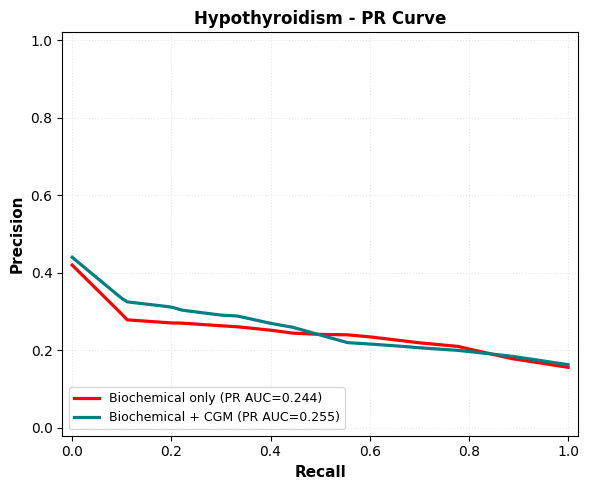

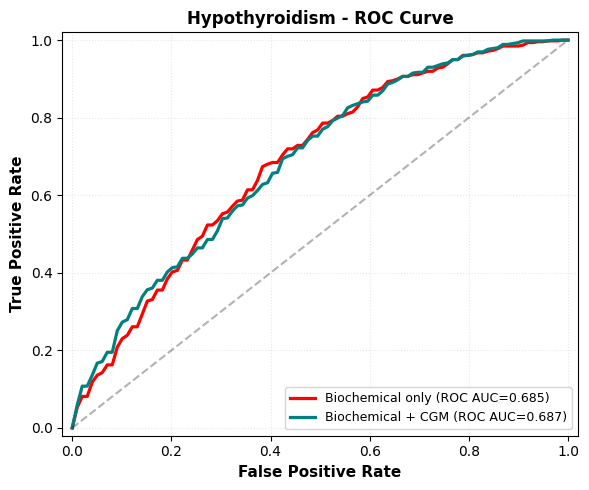

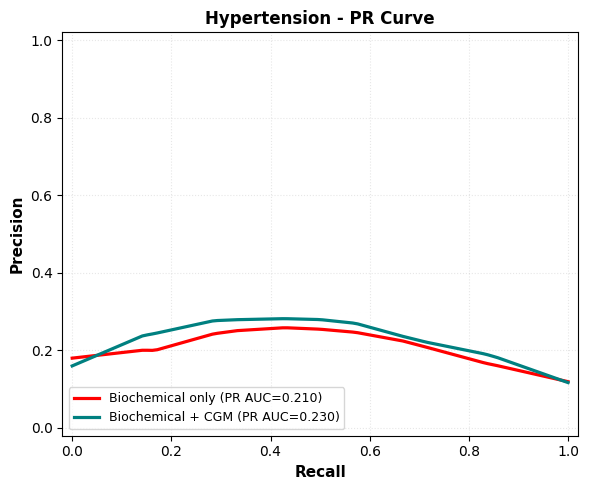

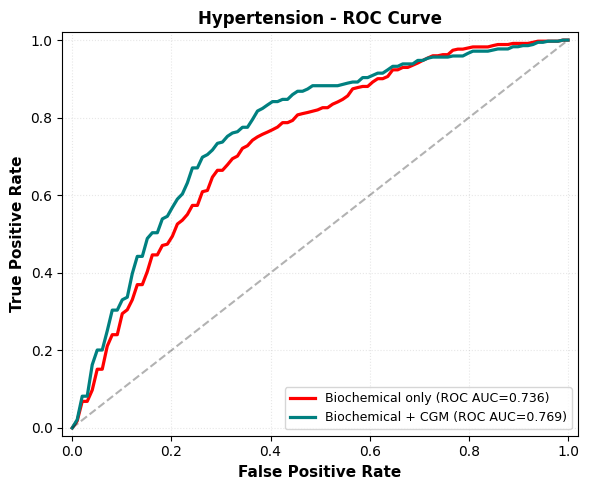

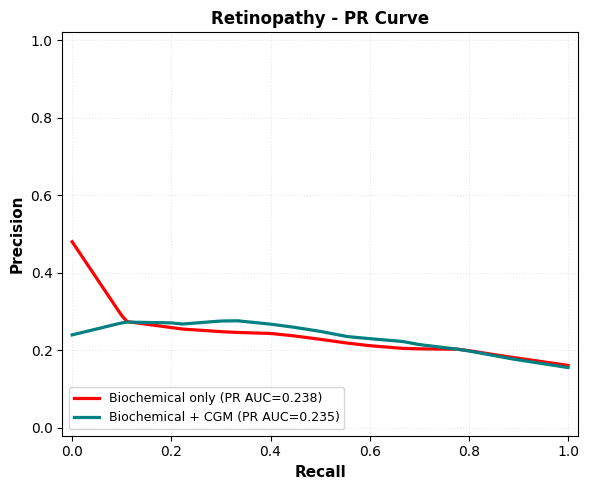

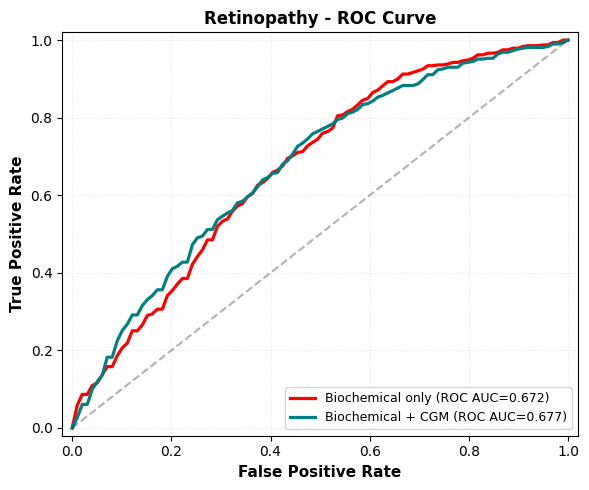

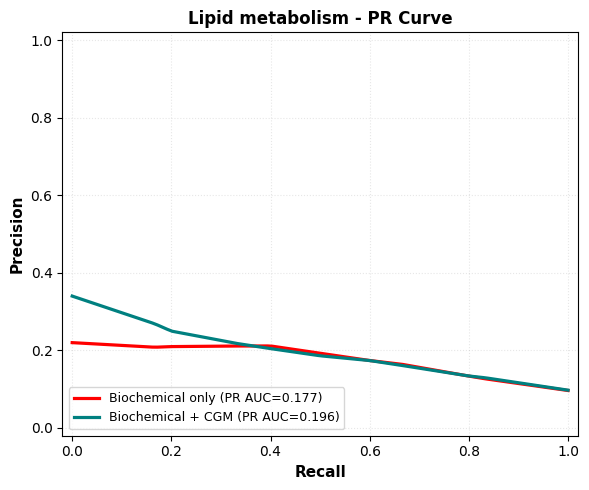

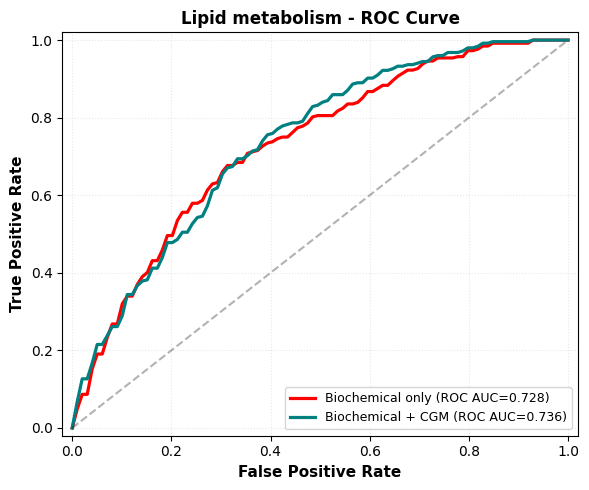

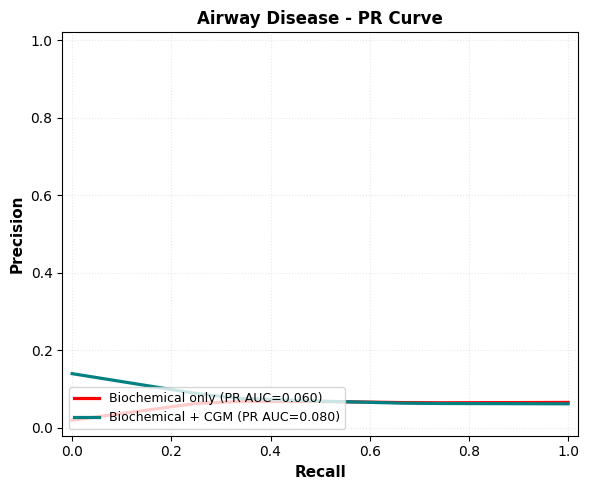

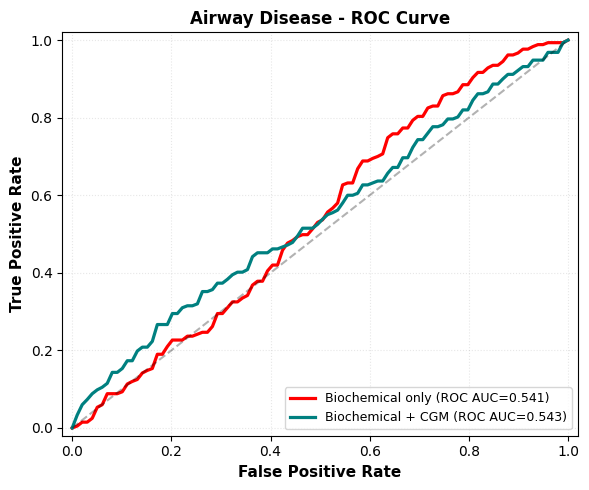

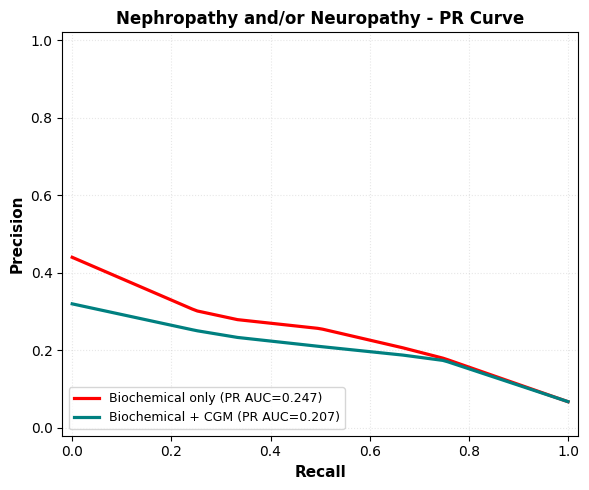

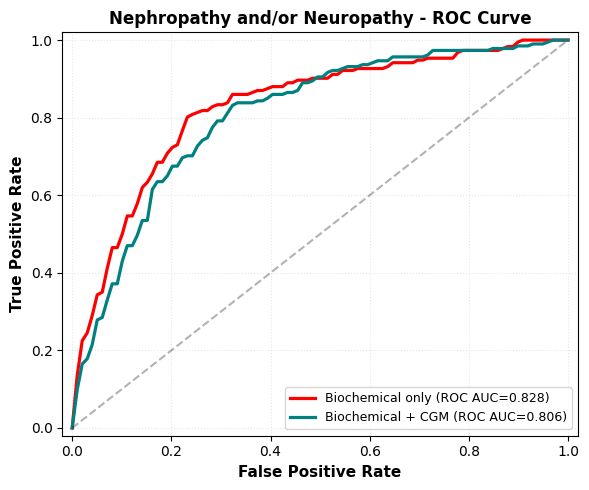

In [37]:
# ---------------------------
# Functions to compute mean curves
# ---------------------------
def mean_pr_curve(y_trues_list, y_preds_list, n_points=100):
    """Compute mean PR curve across folds/seeds."""
    precisions = []
    mean_recall = np.linspace(0, 1, n_points)
    
    for y_true, y_pred in zip(y_trues_list, y_preds_list):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        # Sort and remove duplicates
        sorted_idx = np.argsort(recall)
        recall_sorted = recall[sorted_idx]
        precision_sorted = precision[sorted_idx]
        unique_recall, idx = np.unique(recall_sorted, return_index=True)
        unique_precision = precision_sorted[idx]
        # Interpolate
        precisions.append(np.interp(mean_recall, unique_recall, unique_precision))
    
    mean_precision = np.mean(precisions, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    return mean_recall, mean_precision, mean_auc

def mean_roc_curve(y_trues_list, y_preds_list, n_points=100):
    """Compute mean ROC curve across folds/seeds."""
    tprs = []
    mean_fpr = np.linspace(0, 1, n_points)
    
    for y_true, y_pred in zip(y_trues_list, y_preds_list):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

# ---------------------------
# Plotting both PR and ROC curves per comorbidity
# ---------------------------
conditions = [
    'Hypothyroidism', 
    'Hypertension', 
    'Retinopathy', 
    'Lipid metabolism',
    'Airway Disease',
    'Nephropathy and/or Neuropathy'
]

model_types = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical only',
    'with_cgm': 'Biochemical + CGM'
}
colors = {
    'without_cgm': 'red',
    'with_cgm': '#2d5f8d'
}

for condition in conditions:
    results = all_results[condition]  # dict keyed by seed
    y_trues_all = {m: [] for m in model_types}
    y_preds_all = {m: [] for m in model_types}

    # Aggregate across seeds
    for seed in results:
        for m in model_types:
            y_trues_all[m].extend(results[seed][m]['y_true_folds'])
            y_preds_all[m].extend(results[seed][m]['y_pred_folds'])

    # ---- PR Curve ----
    plt.figure(figsize=(6, 5))
    for m in model_types:
        mean_recall, mean_precision, mean_auc = mean_pr_curve(y_trues_all[m], y_preds_all[m])
        plt.plot(
            mean_recall, mean_precision,
            color=colors[m],
            linewidth=2.3,
            label=f"{model_labels[m]} (PR AUC={mean_auc:.3f})"
        )
    plt.xlabel('Recall', fontsize=11, fontweight='bold')
    plt.ylabel('Precision', fontsize=11, fontweight='bold')
    plt.title(f'{condition} - PR Curve', fontsize=12, fontweight='bold', fontproperties=arial)
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(alpha=0.3, linestyle=':')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.tight_layout()
    plt.show()

    # ---- ROC Curve ----
    plt.figure(figsize=(6, 5))
    for m in model_types:
        mean_fpr, mean_tpr, mean_auc = mean_roc_curve(y_trues_all[m], y_preds_all[m])
        plt.plot(
            mean_fpr, mean_tpr,
            color=colors[m],
            linewidth=2.3,
            label=f"{model_labels[m]} (ROC AUC={mean_auc:.3f})"
        )
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # diagonal
    plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    plt.title(f'{condition} - ROC Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3, linestyle=':')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.tight_layout()
    plt.show()

In [44]:
print("Class distribution:")
print(df_complete['Hypothyroidism'].value_counts())
print(df_complete['Hypertension'].value_counts()) 
print(df_complete['Retinopathy'].value_counts())
print(df_complete['Lipid metabolism'].value_counts())
print(df_complete['Airway Disease'].value_counts())
print(df_complete['Nephropathy and/or Neuropathy'].value_counts())

Class distribution:
Hypothyroidism
0    598
1     91
Name: count, dtype: int64
Hypertension
0    622
1     67
Name: count, dtype: int64
Retinopathy
0    596
1     93
Name: count, dtype: int64
Lipid metabolism
0    637
1     52
Name: count, dtype: int64
Airway Disease
0    652
1     37
Name: count, dtype: int64
Nephropathy and/or Neuropathy
0    651
1     38
Name: count, dtype: int64


In [22]:
# Extract from your data
patient_chars = {
    'Characteristic': [
        'Number of patients',
        'Age (years)',
        'Sex, n (% male)',
        'HbA1c (%)',
        'CGM monitoring days',
        'CGM measurements per patient',
        'Number of biochemical parameters',
        '',
        'Comorbidities, n (%)',
        '  Retinopathy',
        '  Hypothyroidism',
        '  Hypertension',
        '  Lipid metabolism',
        '  Nephropathy and/or Retinopathy',
        '  Airway Disease',
    ],
    'Value': [
    '689',
    f"{df_complete['Age'].mean():.1f} ± {df_complete['Age'].std():.1f}",
    f"{(df_complete['Sex']=='M').sum()} ({(df_complete['Sex']=='M').mean()*100:.1f})",
    f"{df_complete['A1c_mean'].mean():.2f} ± {df_complete['A1c_SD'].mean():.2f}",  # <-- comma here
    f"{df_complete['Number_of_days_with_measures'].median():.0f} " + 
        f"[{df_complete['Number_of_days_with_measures'].quantile(0.25):.0f}-" +
        f"{df_complete['Number_of_days_with_measures'].quantile(0.75):.0f}]",
    f"{df_complete['Number_of_measurements'].median():.0f} " +
        f"[{df_complete['Number_of_measurements'].quantile(0.25):.0f}-" +
        f"{df_complete['Number_of_measurements'].quantile(0.75):.0f}]",
    f"{df_complete['Number_of_biochemical_parameters'].mean():.1f} ± {df_complete['Number_of_biochemical_parameters'].std():.1f}",
    '',
    '',
    f"93 (13.5)",
    f"91 (13.2)",
    f"67 (9.7)",
    f"52 (7.5)",
    f"38 (5.5)",
    f"37 (5.4)"

    ]
}

df_table1 = pd.DataFrame(patient_chars)

# Export to LaTeX
print(df_table1)

# Or export to CSV for Word
df_table1.to_csv('Table1_patient_characteristics.csv', index=False)

                      Characteristic                Value
0                 Number of patients                  689
1                        Age (years)          41.7 ± 15.7
2                    Sex, n (% male)           335 (48.6)
3                          HbA1c (%)          7.89 ± 0.74
4                CGM monitoring days        288 [123-522]
5       CGM measurements per patient  25182 [10682-45199]
6   Number of biochemical parameters         124.7 ± 87.8
7                                                        
8               Comorbidities, n (%)                     
9                        Retinopathy            93 (13.5)
10                    Hypothyroidism            91 (13.2)
11                      Hypertension             67 (9.7)
12                  Lipid metabolism             52 (7.5)
13    Nephropathy and/or Retinopathy             38 (5.5)
14                    Airway Disease             37 (5.4)


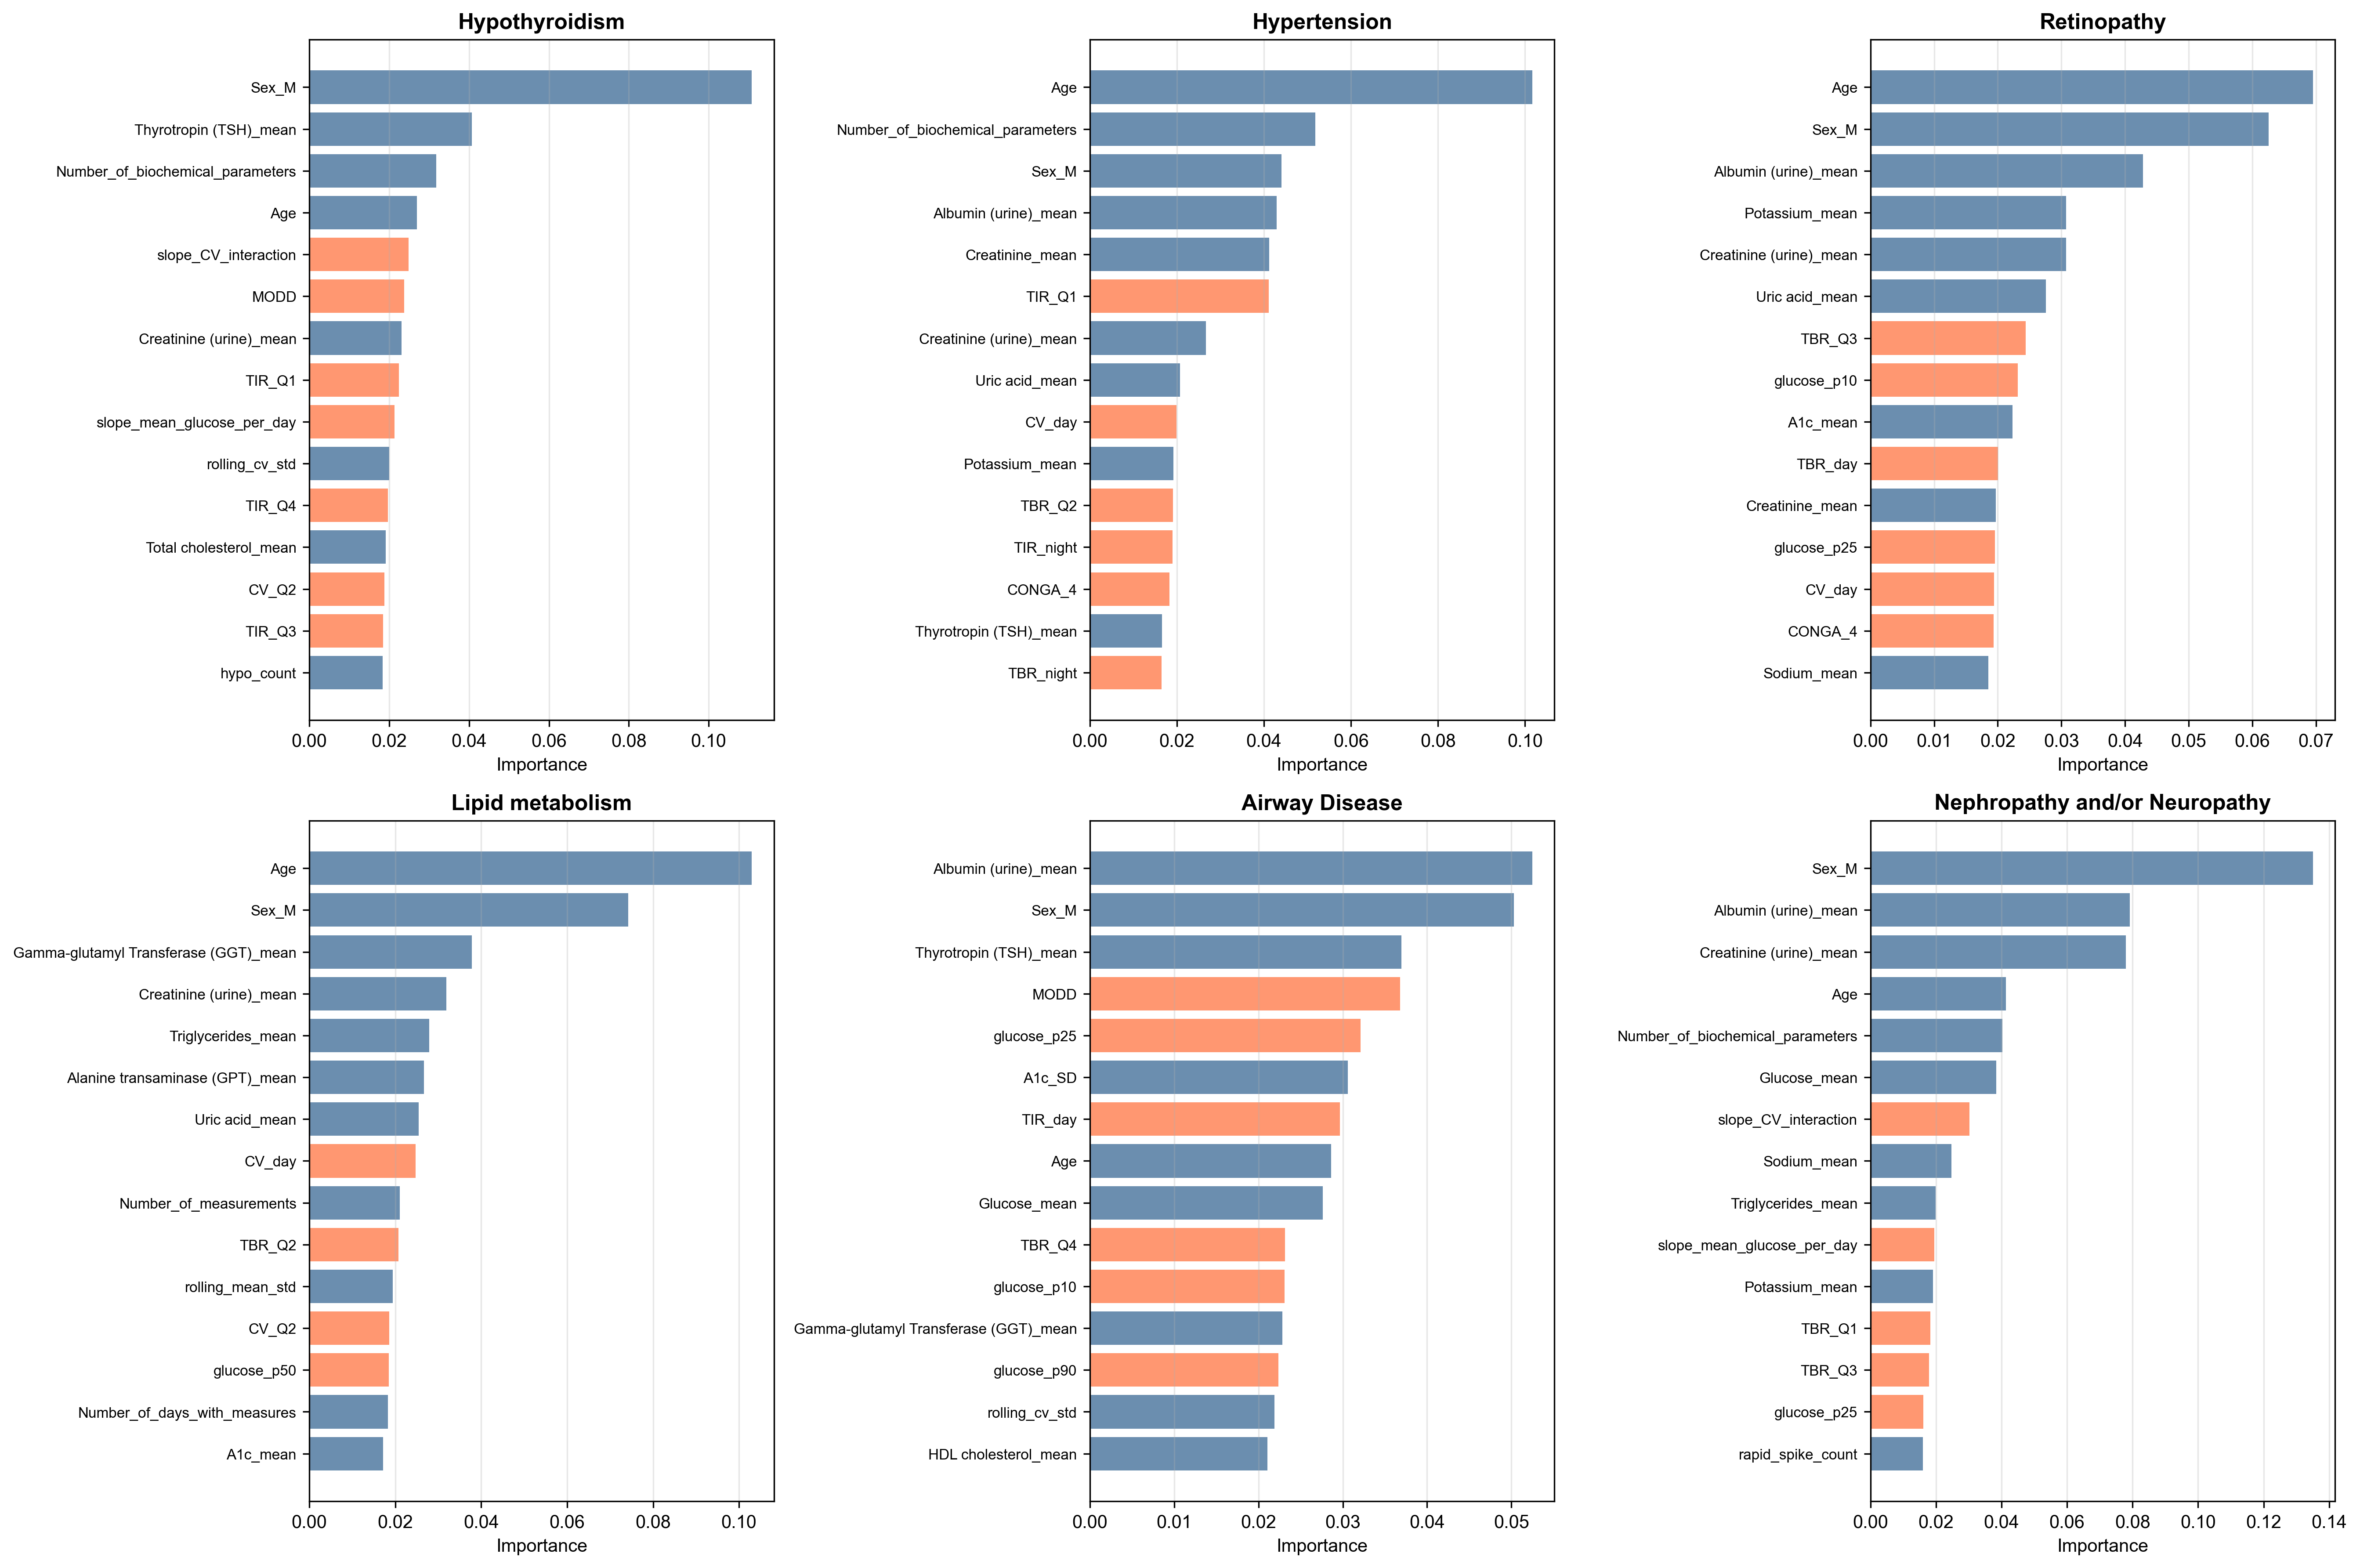

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

custom_titles = ['Hypothyroidism', 'Hypertension', 'Retinopathy', 
                 'Lipid metabolism', 'Airway Disease', 'Nephropathy and/or Neuropathy']

for idx, condition in enumerate(custom_titles):
    ax = axes[idx]
    
    results = all_results[condition]  # dict keyed by seed
    all_importances = []

    # Aggregate feature importances across seeds
    for seed_res in results.values():
        seed_models = seed_res['with_cgm']['models']
        if not seed_models:
            continue
        fold_importances = [m.feature_importances_ for m in seed_models]
        avg_importance_seed = np.mean(fold_importances, axis=0)
        all_importances.append(avg_importance_seed)
    
    if not all_importances:
        continue

    # Average across seeds
    avg_importance = np.mean(all_importances, axis=0)
    
    feat_df = pd.DataFrame({
        'Feature': features_with,
        'Importance': avg_importance
    }).sort_values('Importance', ascending=False).head(15)
    
    # Color code: blue for biochem, orange for CGM features
    colors = ['#2d5f8d' if not any(cgm in f for cgm in ['TIR', 'TBR', 'CV_', 'glucose', 'MODD', 'MAGE', 'CONGA']) 
              else '#ff6b35' for f in feat_df['Feature']]
    
    ax.barh(range(len(feat_df)), feat_df['Importance'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(feat_df)))
    ax.set_yticklabels(feat_df['Feature'], fontsize=8)
    ax.set_xlabel('Importance', fontsize=10)
    ax.set_title(custom_titles[idx], fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()  # optional: largest on top

plt.tight_layout()
plt.savefig('Supplementary_Figure1_all_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
hyperparams = {
    'Hyperparameter': [
        'n_estimators',
        'max_depth',
        'learning_rate',
        'subsample',
        'colsample_bytree',
        'eval_metric',
        'random_state',
        '',
        'Cross-validation',
        'SMOTE sampling_strategy',
        'Feature scaling'
    ],
    'Value': [
        '500',
        '3',
        '0.1',
        '0.8',
        '0.8',
        'logloss',
        '42, 123, 2026, 7, 99',
        '',
        '10-fold stratified',
        '1.0 (balanced)',
        'StandardScaler'
    ]
}

df_supp_table3 = pd.DataFrame(hyperparams)
print(df_supp_table3)

             Hyperparameter                 Value
0              n_estimators                   500
1                 max_depth                     3
2             learning_rate                   0.1
3                 subsample                   0.8
4          colsample_bytree                   0.8
5               eval_metric               logloss
6              random_state  42, 123, 2026, 7, 99
7                                                
8          Cross-validation    10-fold stratified
9   SMOTE sampling_strategy        1.0 (balanced)
10          Feature scaling        StandardScaler


In [25]:
CGM_GROUPS = {
    "variability": [
        "CV_Q1","CV_Q2","CV_Q3","CV_Q4",
        "CV_day","CV_night",
        "MAGE","MODD","CONGA_4"
    ],
    "time_in_range": [
        "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4",
        "TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
        "TIR_day","TIR_night",
        "TBR_day","TBR_night"
    ],
    "temporal_trends": [
        "slope_TIR_per_day",
        "slope_mean_glucose_per_day",
        "rolling_mean_std",
        "rolling_cv_std",
        "slope_CV_interaction"
    ],
    "events": [
        "hypo_count","hyper_count",
        "avg_hypo_duration","avg_hyper_duration",
        "rapid_spike_count"
    ],
    "distribution": [
        "glucose_p10","glucose_p25","glucose_p50",
        "glucose_p75","glucose_p90"
    ]
}

ALL_CGM_FEATURES = sorted(
    set().union(*CGM_GROUPS.values())
)

ablation_results = {}

for group_name, group_features in CGM_GROUPS.items():
    ablation_results[group_name] = []

    ablated_features = sorted(
        set(ALL_CGM_FEATURES) - set(group_features)
    )

    for seed in seeds:
        results, _, _, _ = run_cross_validation_xgboost(
            df_complete,
            target_col="Hypertension",
            cgm_subset=ablated_features,
            n_splits=10,
            random_state=seed
        )

        ablation_results[group_name].append(
            np.mean(results["with_cgm"]["roc_auc"])
        )

    print(
        f"Ablate {group_name}: "
        f"{np.mean(ablation_results[group_name]):.3f} ± "
        f"{np.std(ablation_results[group_name]):.3f}"
    )


Fold  1: With=0.892, Without=0.833, Only=0.656
Fold  2: With=0.823, Without=0.807, Only=0.455
Fold  3: With=0.933, Without=0.885, Only=0.677
Fold  4: With=0.671, Without=0.756, Only=0.341
Fold  5: With=0.645, Without=0.684, Only=0.597
Fold  6: With=0.742, Without=0.719, Only=0.627
Fold  7: With=0.850, Without=0.638, Only=0.673
Fold  8: With=0.705, Without=0.641, Only=0.491
Fold  9: With=0.753, Without=0.680, Only=0.399
Fold 10: With=0.761, Without=0.731, Only=0.602
Fold  1: With=0.831, Without=0.709, Only=0.447
Fold  2: With=0.690, Without=0.709, Only=0.532
Fold  3: With=0.687, Without=0.684, Only=0.516
Fold  4: With=0.834, Without=0.834, Only=0.438
Fold  5: With=0.631, Without=0.578, Only=0.509
Fold  6: With=0.735, Without=0.668, Only=0.724
Fold  7: With=0.735, Without=0.740, Only=0.512
Fold  8: With=0.790, Without=0.615, Only=0.456
Fold  9: With=0.899, Without=0.889, Only=0.576
Fold 10: With=0.866, Without=0.933, Only=0.478
Fold  1: With=0.762, Without=0.656, Only=0.561
Fold  2: With

In [26]:
def plot_shap_summary(explainer, X_test, feature_names,
                      condition='Hypertension',
                      display=True):
    """
    Two stacked panels:
      A) Beeswarm (directionality)
      B) Mean |SHAP| bar plot
    """

    print("Computing SHAP values...")
    shap_values_all = explainer.shap_values(X_test)
    
    # DEBUG: Check what we got
    print(f"SHAP values type: {type(shap_values_all)}")
    
    # Extract SHAP values for the positive class (hypertension)
    if isinstance(shap_values_all, list):
        print(f"SHAP values is a list with {len(shap_values_all)} elements")
        print("Assuming index 1 = hypertension class (positive class)")
        shap_values = shap_values_all[1]  # Class 1 = hypertension
    else:
        shap_values = shap_values_all
    
    print(f"Using SHAP values shape: {shap_values.shape}")
    
    # Ensure X_test is in correct format for SHAP
    if not isinstance(X_test, np.ndarray):
        X_test_array = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
    else:
        X_test_array = X_test

    # ---------- Panel A: Beeswarm ----------
    plt.figure(figsize=(8, 10))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="dot",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"B. Feature Impact on {condition} Risk",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("SHAP value (impact on model output)", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()

    # ---------- Panel B: Mean |SHAP| ----------
    plt.figure(figsize=(8, 8))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="bar",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title("A. Feature Importance Magnitude",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("Mean |SHAP value|", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()

    # Calculate SHAP importance
    shap_importance = pd.DataFrame({
        "Feature": feature_names,
        "Mean_|SHAP|": np.abs(shap_values).mean(axis=0),
        "Mean_SHAP": shap_values.mean(axis=0)
    }).sort_values("Mean_|SHAP|", ascending=False)

    return shap_values, shap_importance


# Also modify the run_complete_interpretability_pipeline function:
def run_complete_interpretability_pipeline(model, X_test, y_test,
                                           feature_names,
                                           condition='Hypertension',
                                           save_dir='figures/',
                                           display=True):  # Add display parameter

    print("\nRunning focused interpretability pipeline...")

    # 1. SHAP summary
    explainer = shap.TreeExplainer(model)
    shap_values, shap_importance = plot_shap_summary(
        explainer,
        X_test,
        feature_names,
        condition,
        display=display  # Pass display parameter
    )

    print("\nCore interpretability figures generated.")
    return {
        "shap_importance": shap_importance,
        "shap_values": shap_values
    }


Running focused interpretability pipeline...
Computing SHAP values...
SHAP values type: <class 'numpy.ndarray'>
Using SHAP values shape: (69, 56)


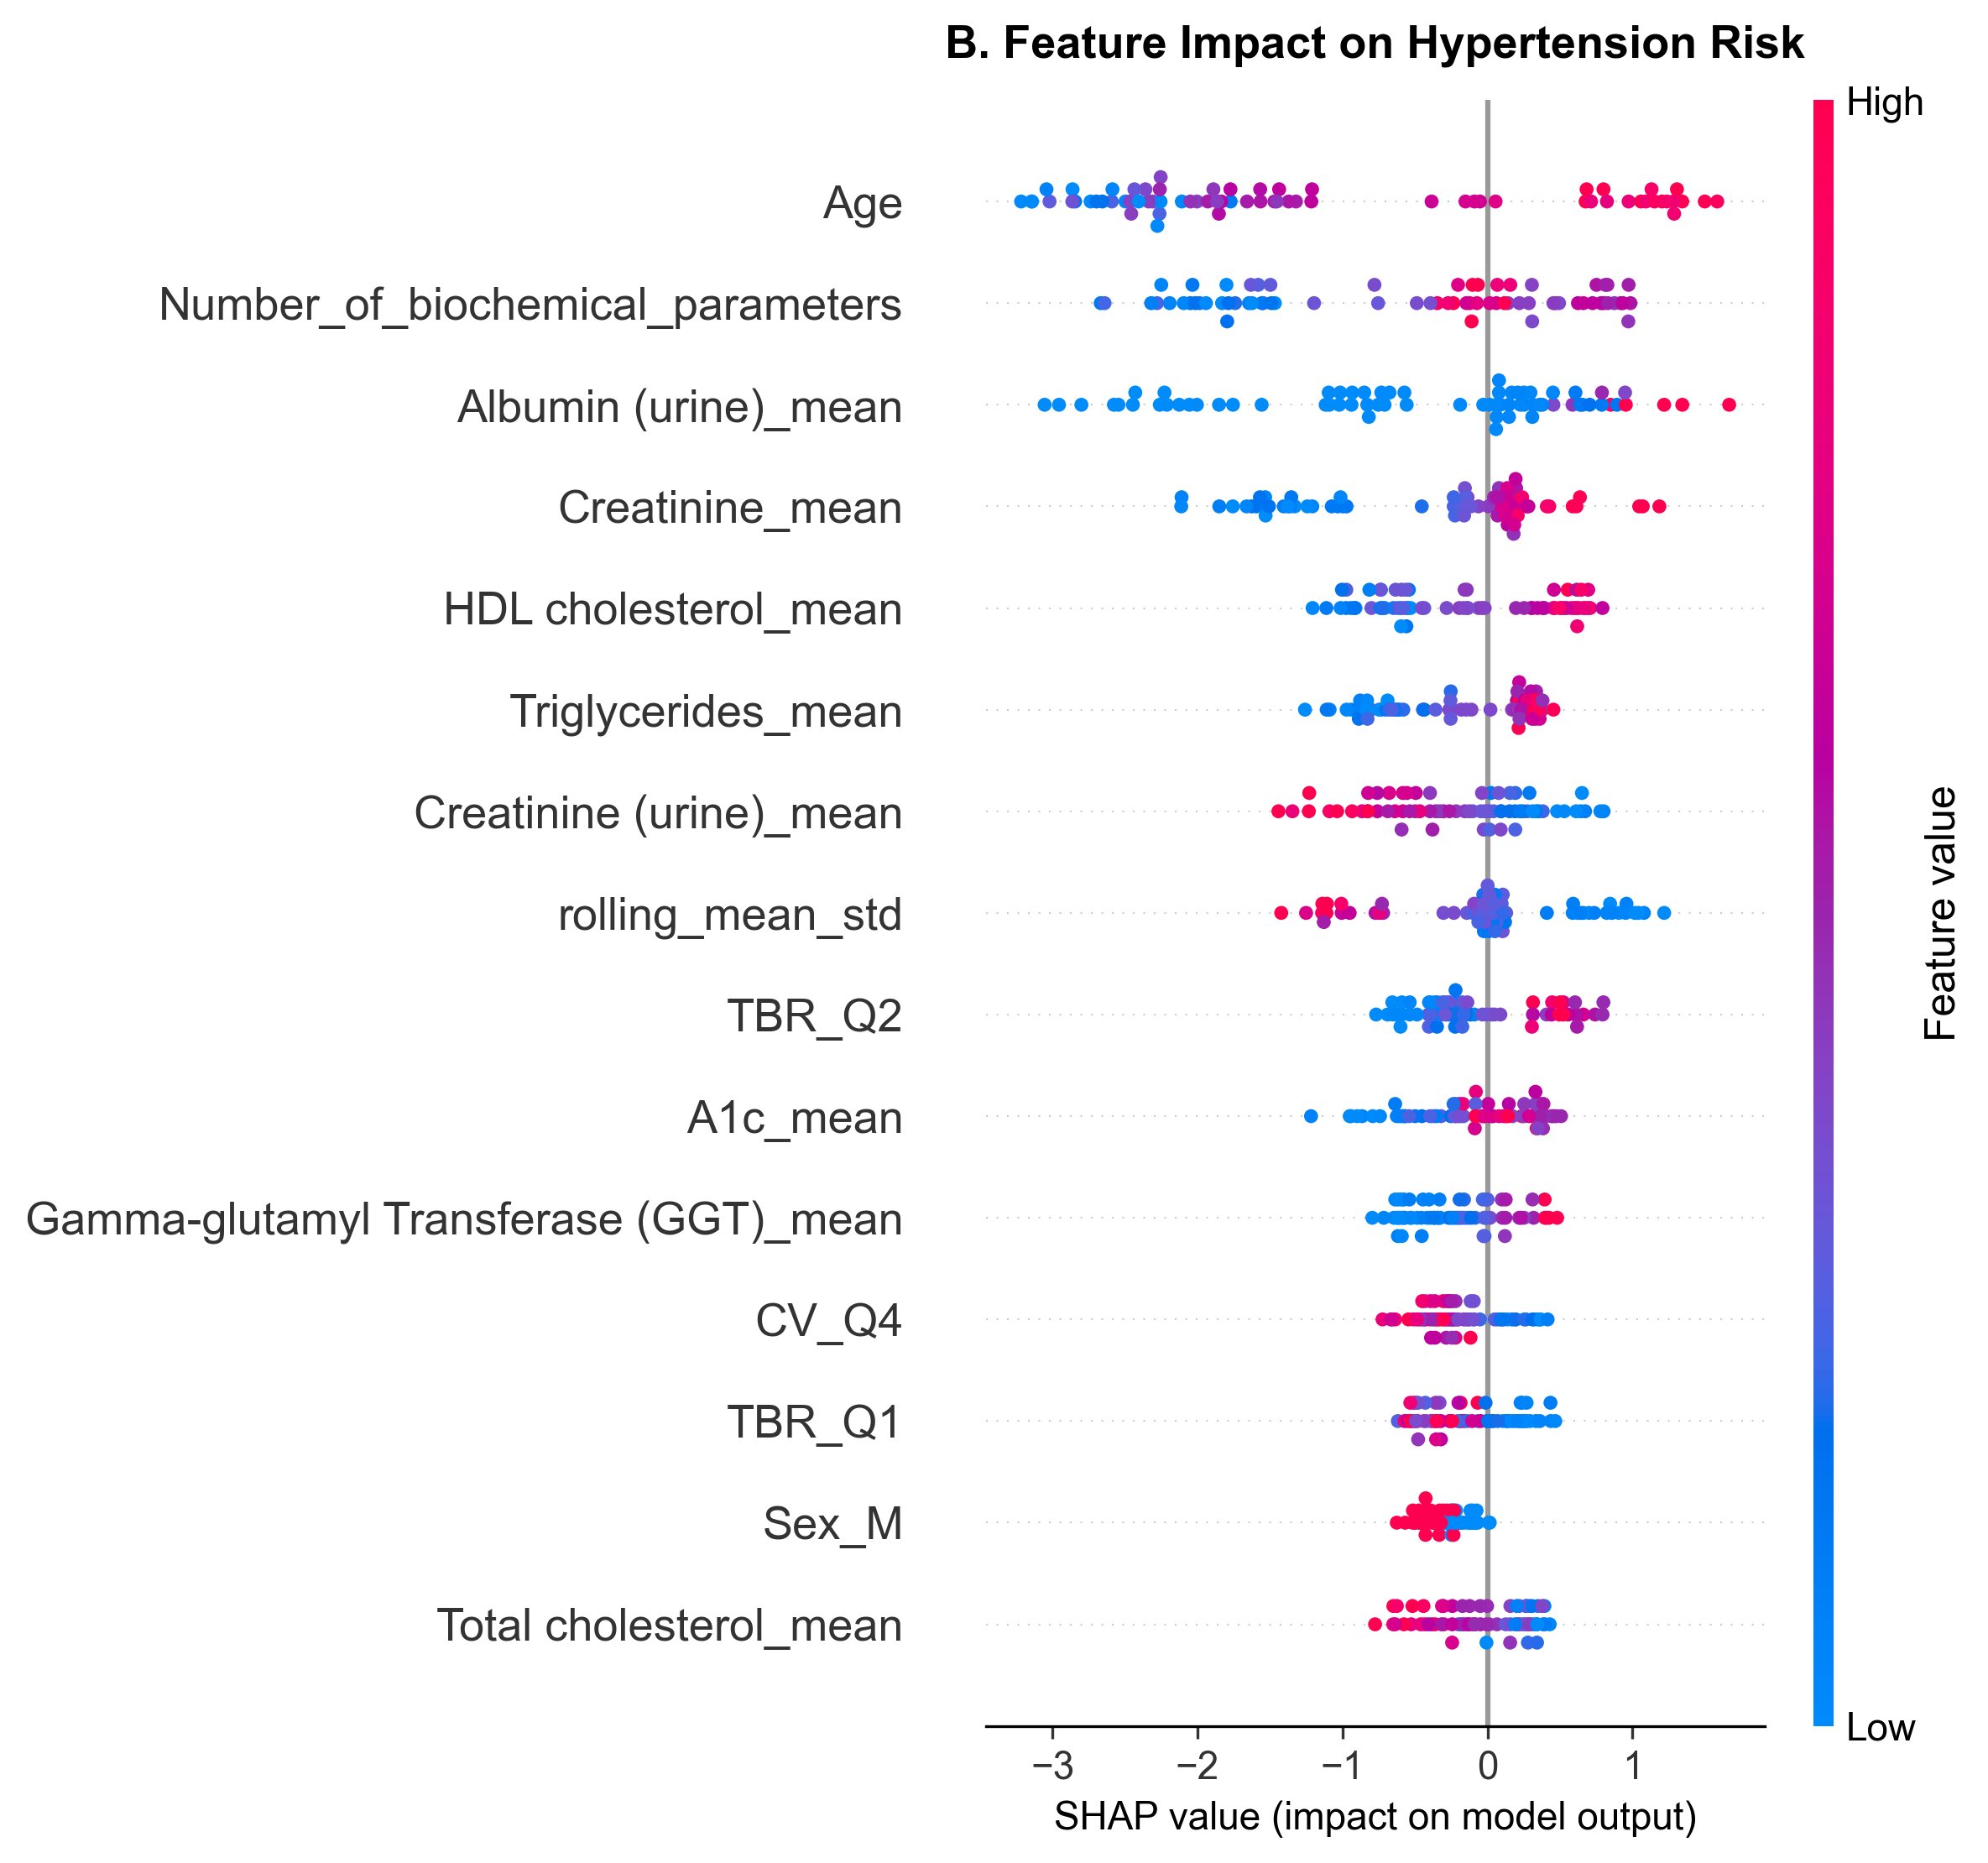

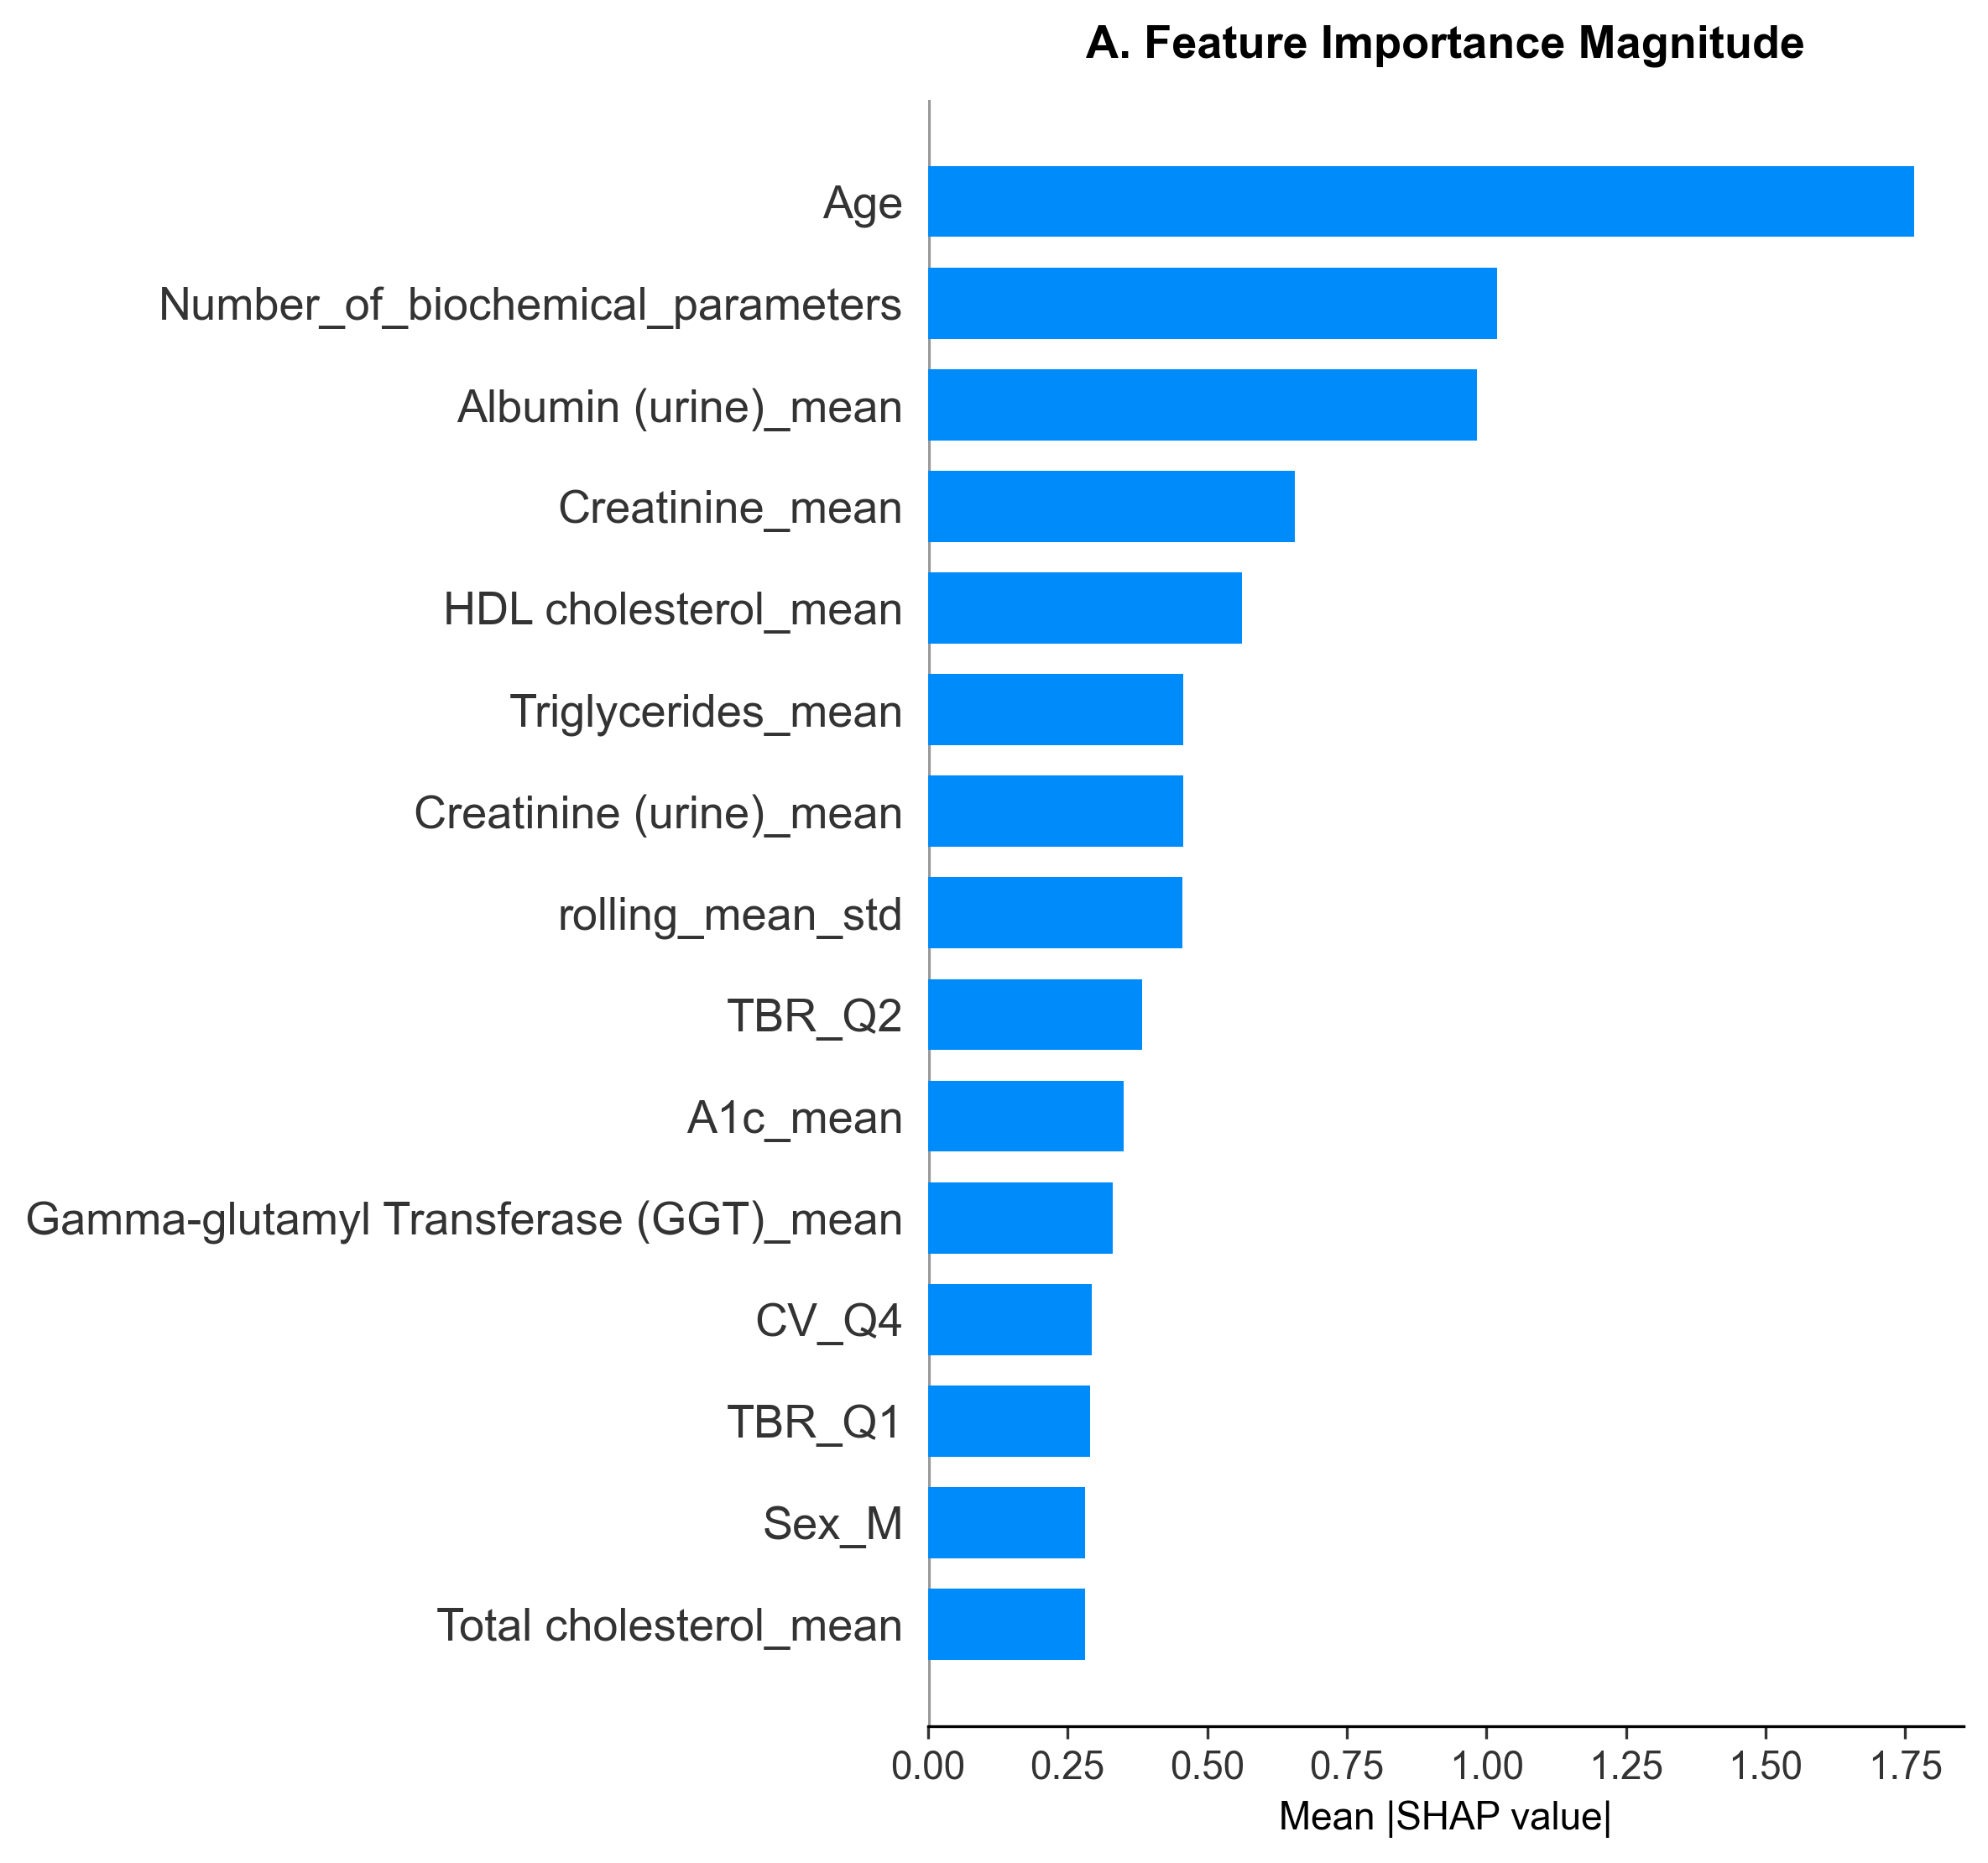


Core interpretability figures generated.

Top 20 Most Important Features:
                                  Feature  Mean_|SHAP|  Mean_SHAP
41                                    Age     1.766588  -1.189427
40       Number_of_biochemical_parameters     1.019070  -0.567500
43                   Albumin (urine)_mean     0.983198  -0.488603
44                        Creatinine_mean     0.656351  -0.376811
48                   HDL cholesterol_mean     0.562642  -0.135966
53                     Triglycerides_mean     0.457465  -0.174814
45                Creatinine (urine)_mean     0.457142  -0.198719
19                       rolling_mean_std     0.455587   0.005400
5                                  TBR_Q2     0.383661  -0.081180
36                               A1c_mean     0.350433  -0.096068
46  Gamma-glutamyl Transferase (GGT)_mean     0.330755  -0.214055
11                                  CV_Q4     0.293481  -0.184704
4                                  TBR_Q1     0.289482  -0.126666
5

In [29]:
# After running cross-validation
condition = 'Hypertension'
seed = 42
results = all_results[condition][seed]

# Pick a fold (e.g., fold 0)
fold_idx = 0
model = results['with_cgm']['models'][fold_idx]
X_test = results['with_cgm']['X_test_scaled'][fold_idx]
feature_names = results['feature_names']['with_cgm']

# Run SHAP and display plots
shap_result = run_complete_interpretability_pipeline(
    model=model,
    X_test=X_test,
    y_test=results['with_cgm']['y_true_folds'][fold_idx],
    feature_names=feature_names,
    condition=condition,
    display=True  # This will show the plots
)

# Print the top features
print("\nTop 20 Most Important Features:")
print(shap_result["shap_importance"].head(20).to_string())

SHAP values shape: (69, 56)
Expected: (69, 56)

COUNTERFACTUAL PROXY ANALYSIS: Hypertension False Negatives

=== INPUT DIAGNOSTICS ===
X_test shape: (69, 56)
SHAP values shape: (69, 56)
Number of features: 56
y_test shape: (69,)
y_pred_proba shape: (69,)

=== FALSE NEGATIVE STATISTICS ===
Found 3 false-negative cases (threshold=0.3)
Predicted risk range in FN: [0.004, 0.016]
Mean predicted risk in FN: 0.009

=== SEX FEATURE ANALYSIS ===
Using sex feature: 'Sex_M' at index 55
Sex distribution in false negatives: {np.float64(-0.9745181037780646): np.int64(1), np.float64(1.026148201991472): np.int64(2)}

=== PATIENT SELECTION ===
Random state: 42
Using all 3 false negative cases
Selected patient indices: [ 6 13 19]

=== VERIFYING PATIENT UNIQUENESS ===
Unique patients in selection: 3/3

✓ Counterfactual analysis saved to: figures/counterfactual_analysis.png


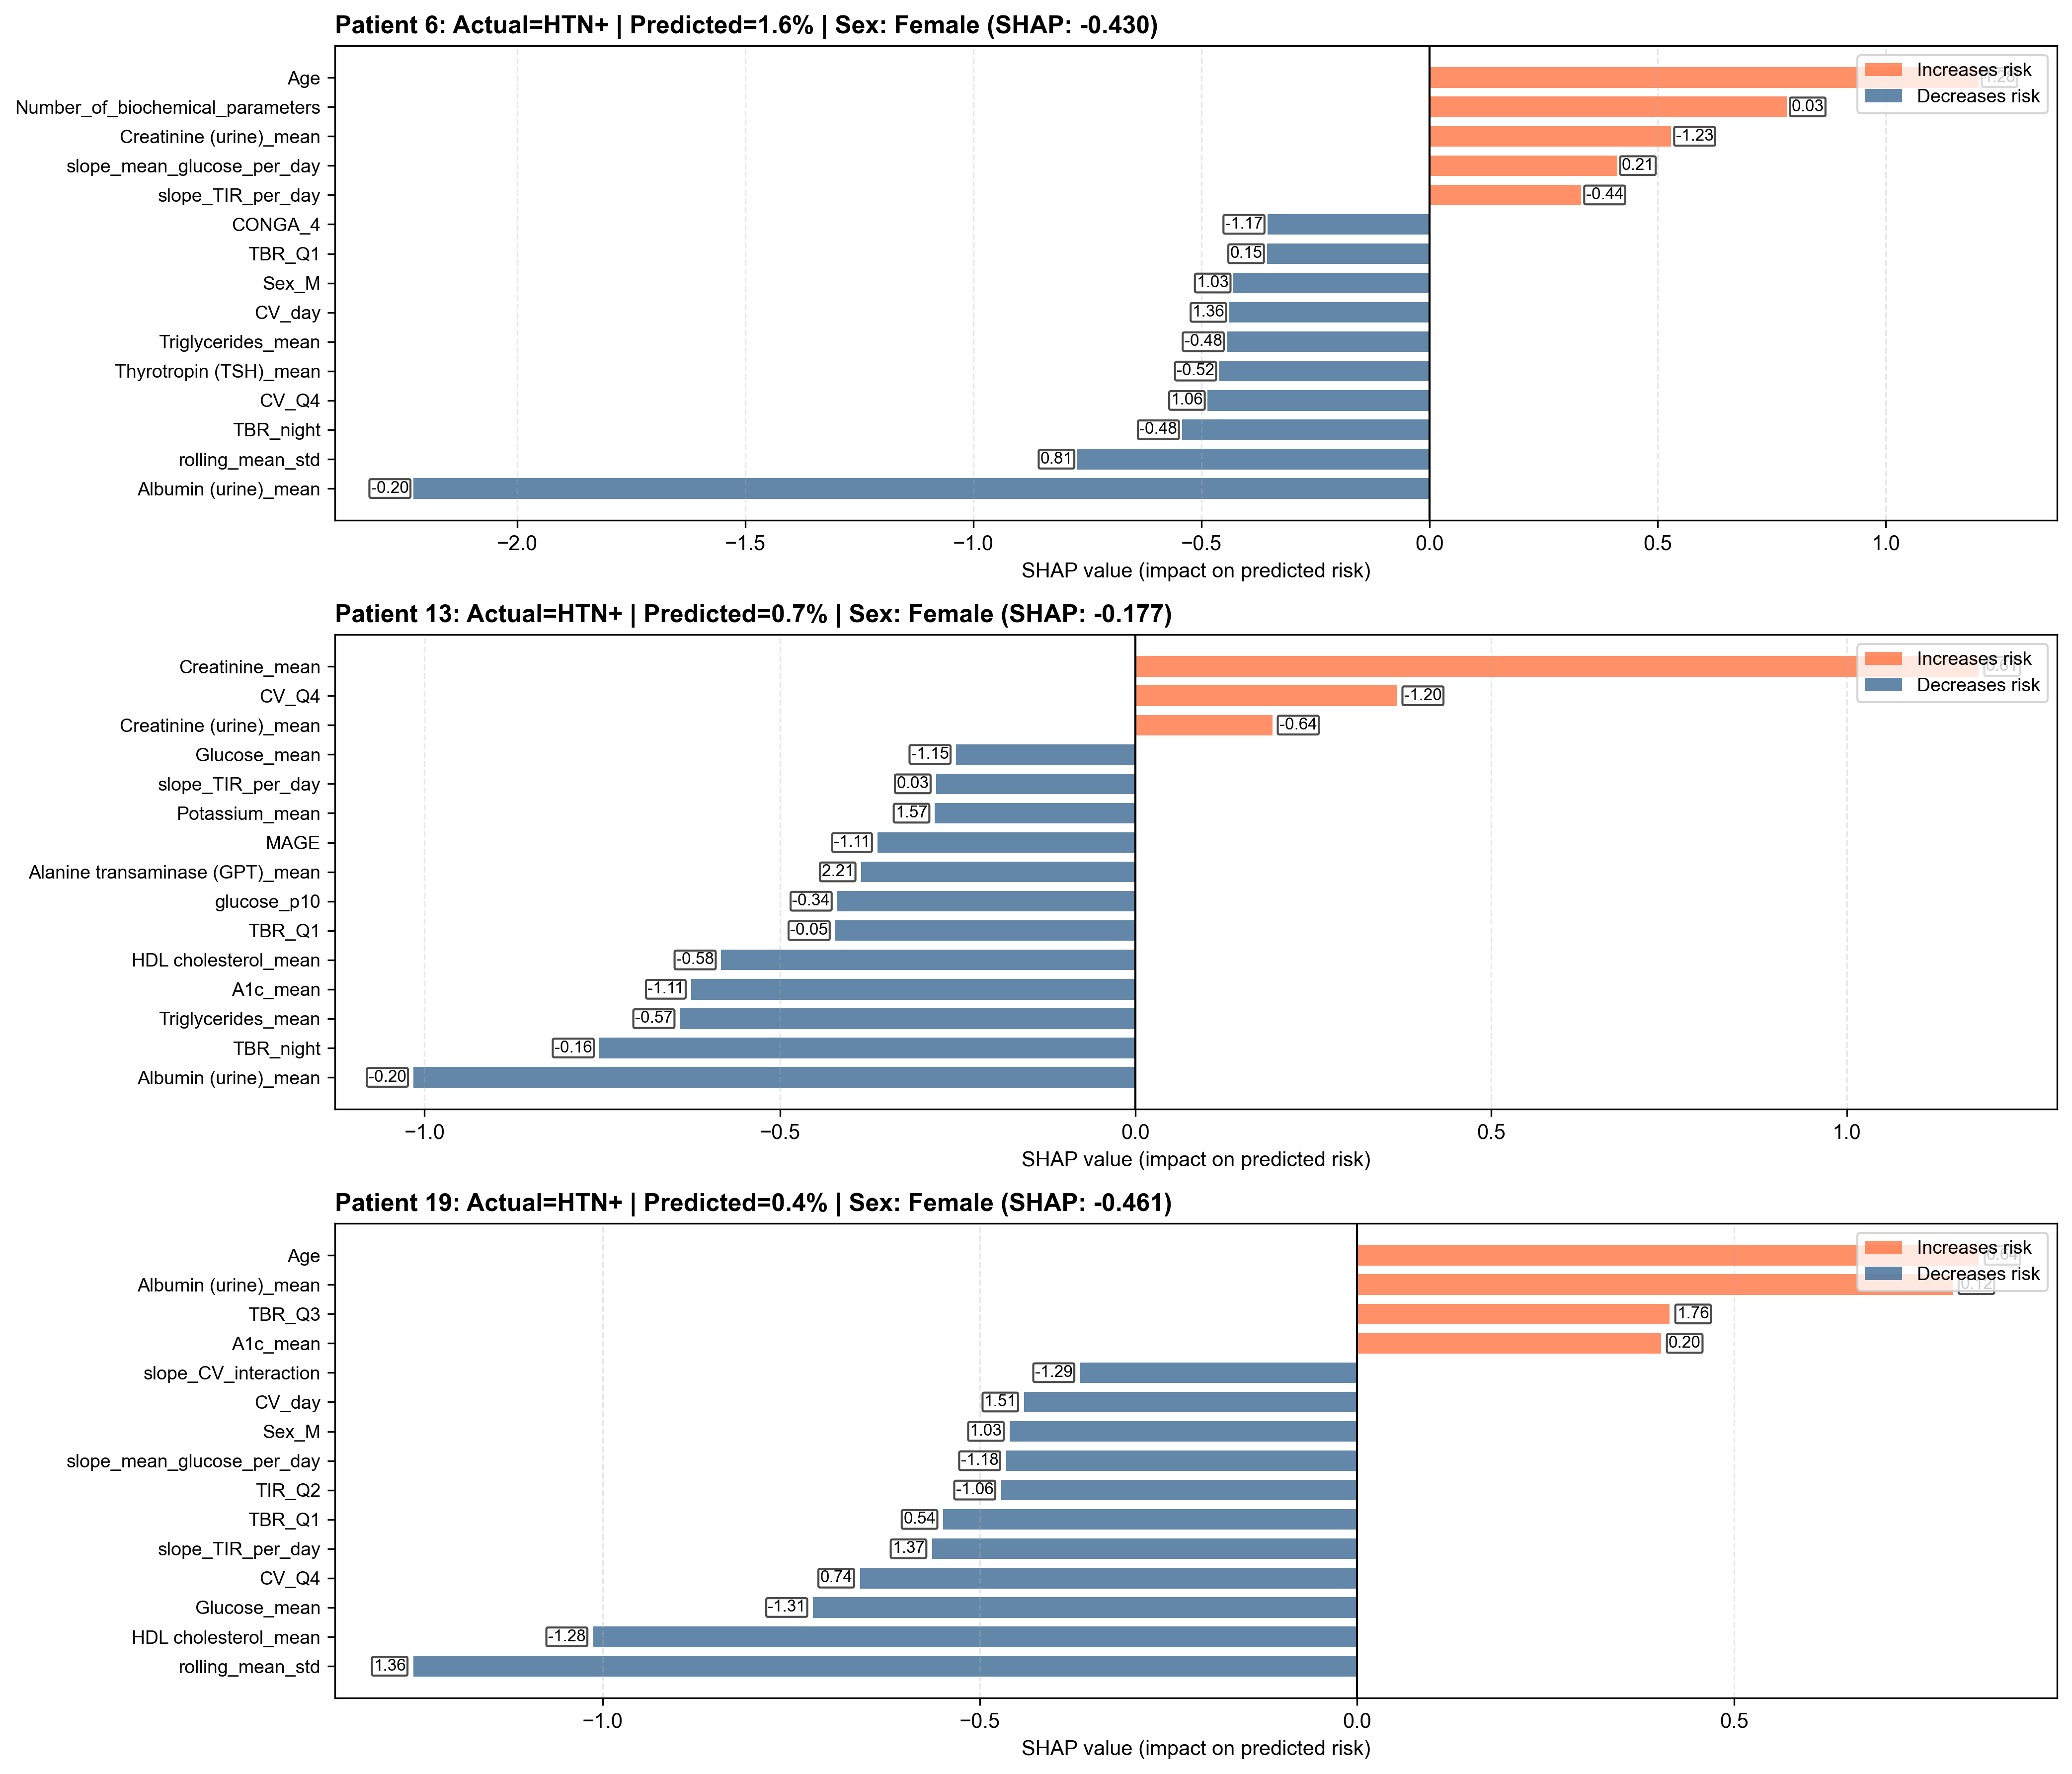


DETAILED PATIENT INSIGHTS

PATIENT 1: Index 6
• Predicted hypertension risk: 1.65%
• Actual outcome: Hypertensive (False Negative)
• Sex: Female (SHAP: -0.4299)

TOP PROTECTIVE FACTORS (reduced risk):
  • Albumin (urine)_mean: -0.20 (↓) → SHAP: -2.2275
  • rolling_mean_std: 0.81 (↓) → SHAP: -0.7723
  • TBR_night: -0.48 (↓) → SHAP: -0.5430
  • CV_Q4: 1.06 (↓) → SHAP: -0.4864
  • Thyrotropin (TSH)_mean: -0.52 (↓) → SHAP: -0.4615

TOP RISK FACTORS (increased risk):
  • Age: 1.28 (↓) → SHAP: 1.2041
  • Number_of_biochemical_parameters: 0.03 (↓) → SHAP: 0.7834
  • Creatinine (urine)_mean: -1.23 (↓) → SHAP: 0.5299
  • slope_mean_glucose_per_day: 0.21 (↓) → SHAP: 0.4114
  • slope_TIR_per_day: -0.44 (↓) → SHAP: 0.3327

COUNTERFACTUAL INSIGHT:
  If Albumin (urine)_mean were at median level, 
  predicted risk would increase by ~2.228

PATIENT 2: Index 13
• Predicted hypertension risk: 0.65%
• Actual outcome: Hypertensive (False Negative)
• Sex: Female (SHAP: -0.1766)

TOP PROTECTIVE FACTORS (re

In [34]:
def counterfactual_analysis_misclassified(
    model,
    X_test,
    y_test,
    y_pred_proba,
    shap_values,
    feature_names,
    n_examples=5,
    threshold=0.3,
    random_state=42,
    save_path='figures/counterfactual_analysis.png'
):
    """
    SHAP-based counterfactual proxy analysis on false-negative cases.
    Identifies features that most strongly suppressed predicted risk
    in patients who developed hypertension but were predicted low-risk.
    
    Parameters:
    -----------
    random_state : int
        Seed for reproducible random selection of patients
    """

    print("\n" + "=" * 70)
    print("COUNTERFACTUAL PROXY ANALYSIS: Hypertension False Negatives")
    print("=" * 70 + "\n")
    
    # ------------------------------------------------------------
    # DIAGNOSTICS: Check inputs
    # ------------------------------------------------------------
    print("=== INPUT DIAGNOSTICS ===")
    print(f"X_test shape: {X_test.shape}")
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Number of features: {len(feature_names)}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_pred_proba shape: {y_pred_proba.shape}")
    
    # Ensure y_pred_proba is 1D array
    if len(y_pred_proba.shape) > 1:
        y_pred_proba = y_pred_proba.flatten()
        print("Flattened y_pred_proba to 1D array")

    # ------------------------------------------------------------
    # Identify false negatives
    # ------------------------------------------------------------
    false_negatives = (y_test == 1) & (y_pred_proba < threshold)
    fn_indices = np.where(false_negatives)[0]

    print(f"\n=== FALSE NEGATIVE STATISTICS ===")
    print(f"Found {len(fn_indices)} false-negative cases (threshold={threshold})")
    
    if len(fn_indices) == 0:
        print("No false negatives found — aborting counterfactual analysis.")
        return None

    # Show distribution of predicted probabilities
    print(f"Predicted risk range in FN: [{y_pred_proba[fn_indices].min():.3f}, "
          f"{y_pred_proba[fn_indices].max():.3f}]")
    print(f"Mean predicted risk in FN: {y_pred_proba[fn_indices].mean():.3f}")

    # ------------------------------------------------------------
    # Convert X_test to DataFrame for consistent handling
    # ------------------------------------------------------------
    if not hasattr(X_test, "iloc"):
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
    else:
        X_test_df = X_test.copy()
        if hasattr(X_test, 'columns'):
            X_test_df.columns = feature_names

    # ------------------------------------------------------------
    # Detect sex feature (if present)
    # ------------------------------------------------------------
    sex_feature = None
    sex_idx = None
    for feat in feature_names:
        if feat.lower() in ['sex', 'sex_m', 'male', 'is_male'] or 'sex' in feat.lower():
            sex_feature = feat
            sex_idx = feature_names.index(feat)
            break

    if sex_feature is not None:
        print(f"\n=== SEX FEATURE ANALYSIS ===")
        print(f"Using sex feature: '{sex_feature}' at index {sex_idx}")
        
        # Check sex distribution
        sex_values = X_test_df.iloc[fn_indices][sex_feature].values
        unique_vals, counts = np.unique(sex_values, return_counts=True)
        sex_dist = dict(zip(unique_vals, counts))
        print(f"Sex distribution in false negatives: {sex_dist}")
        
        # Check SHAP values for sex
        male_mask = sex_values == 1
        female_mask = sex_values == 0
        
        if np.any(male_mask):
            male_shap = shap_values[fn_indices][male_mask, sex_idx]
            print(f"Male (1) in FN: {male_shap.shape[0]} cases, "
                  f"Mean SHAP = {male_shap.mean():.4f}")
        
        if np.any(female_mask):
            female_shap = shap_values[fn_indices][female_mask, sex_idx]
            print(f"Female (0) in FN: {female_shap.shape[0]} cases, "
                  f"Mean SHAP = {female_shap.mean():.4f}")

    # ------------------------------------------------------------
    # SELECT DIVERSE PATIENTS (Key Fix!)
    # ------------------------------------------------------------
    print(f"\n=== PATIENT SELECTION ===")
    print(f"Random state: {random_state}")
    np.random.seed(random_state)
    
    if len(fn_indices) <= n_examples:
        # Use all false negatives if we don't have enough
        selected_fn = fn_indices
        print(f"Using all {len(fn_indices)} false negative cases")
    else:
        # Option A: Random selection
        selected_fn = np.random.choice(fn_indices, size=n_examples, replace=False)
        selected_fn = np.sort(selected_fn)  # Sort for clean display
        print(f"Randomly selected {n_examples} cases")
        
        # Option B: Diverse selection across risk spectrum (uncomment if preferred)
        # # Sort by predicted probability and take evenly spaced samples
        # sorted_indices = fn_indices[np.argsort(y_pred_proba[fn_indices])]
        # step = max(1, len(sorted_indices) // n_examples)
        # selected_fn = sorted_indices[::step][:n_examples]
        # print(f"Selected {n_examples} cases across risk spectrum")
    
    print(f"Selected patient indices: {selected_fn}")
    
    # Verify these are actually different patients
    print("\n=== VERIFYING PATIENT UNIQUENESS ===")
    patient_data = X_test_df.iloc[selected_fn]
    
    # Check for near-duplicates (values very similar)
    similarity_threshold = 0.95  # 95% similarity
    n_unique = len(patient_data.drop_duplicates())
    print(f"Unique patients in selection: {n_unique}/{len(selected_fn)}")
    
    if n_unique < len(selected_fn):
        print("WARNING: Some patients appear similar/duplicated!")
        # Show the most similar pair
        from scipy.spatial.distance import pdist, squareform
        distances = pdist(patient_data.values, metric='euclidean')
        dist_matrix = squareform(distances)
        np.fill_diagonal(dist_matrix, np.inf)
        min_dist = dist_matrix.min()
        print(f"Minimum Euclidean distance between patients: {min_dist:.4f}")

    # ------------------------------------------------------------
    # VISUALIZATION
    # ------------------------------------------------------------
    n_show = len(selected_fn)
    fig, axes = plt.subplots(n_show, 1, figsize=(14, 4 * n_show))
    if n_show == 1:
        axes = [axes]

    for ax, idx in zip(axes, selected_fn):
        patient_shap = shap_values[idx]
        patient_features = X_test_df.iloc[idx]

        # Create DataFrame with feature information
        df_patient = pd.DataFrame({
            "Feature": feature_names,
            "SHAP": patient_shap,
            "Value": patient_features.values
        })
        
        # Sort by absolute SHAP value for importance
        df_sorted = df_patient.copy()
        df_sorted["abs_SHAP"] = np.abs(df_sorted["SHAP"])
        df_sorted = df_sorted.sort_values("abs_SHAP", ascending=False).head(15)
        
        # Now sort by actual SHAP for visualization
        df_sorted = df_sorted.sort_values("SHAP", ascending=False)
        
        # Plot
        colors = ['#ff6b35' if s > 0 else '#2d5f8d' for s in df_sorted["SHAP"]]
        
        bars = ax.barh(
            range(len(df_sorted)),
            df_sorted["SHAP"],
            color=colors,
            alpha=0.75,
            height=0.7
        )
        
        # Add value labels on bars
        for i, (shap_val, feat_val) in enumerate(zip(df_sorted["SHAP"], df_sorted["Value"])):
            x_pos = shap_val + (0.01 if shap_val >= 0 else -0.01)
            ha = 'left' if shap_val >= 0 else 'right'
            ax.text(x_pos, i, f"{feat_val:.2f}", 
                   va='center', ha=ha, fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.7))
        
        ax.set_yticks(range(len(df_sorted)))
        ax.set_yticklabels(df_sorted["Feature"], fontsize=9)
        ax.axvline(0, color="black", linewidth=1.0, linestyle='-')
        
        # Add sex info to title
        sex_info = ""
        if sex_feature is not None:
            sex_val = patient_features[sex_feature]
            sex_shap = patient_shap[sex_idx]
            sex_info = f" | Sex: {'Male' if sex_val == 1 else 'Female'} (SHAP: {sex_shap:.3f})"
        
        ax.set_title(
            f"Patient {idx}: Actual=HTN+ | Predicted={y_pred_proba[idx]:.1%}{sex_info}",
            fontsize=12,
            fontweight="bold",
            loc='left'
        )
        ax.set_xlabel("SHAP value (impact on predicted risk)", fontsize=10)
        ax.invert_yaxis()
        ax.grid(axis="x", alpha=0.3, linestyle='--')
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#ff6b35', alpha=0.75, label='Increases risk'),
            Patch(facecolor='#2d5f8d', alpha=0.75, label='Decreases risk')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\n✓ Counterfactual analysis saved to: {save_path}")
    plt.show()

    # ------------------------------------------------------------
    # DETAILED TEXT INSIGHTS
    # ------------------------------------------------------------
    print("\n" + "=" * 70)
    print("DETAILED PATIENT INSIGHTS")
    print("=" * 70)
    
    for i, idx in enumerate(selected_fn[:min(5, len(selected_fn))], 1):
        df = pd.DataFrame({
            "Feature": feature_names,
            "SHAP": shap_values[idx],
            "Value": X_test_df.iloc[idx].values
        })
        
        print(f"\n{'='*40}")
        print(f"PATIENT {i}: Index {idx}")
        print(f"{'='*40}")
        print(f"• Predicted hypertension risk: {y_pred_proba[idx]:.2%}")
        print(f"• Actual outcome: Hypertensive (False Negative)")
        
        if sex_feature is not None:
            sex_val = X_test_df.iloc[idx][sex_feature]
            sex_shap = shap_values[idx][sex_idx]
            print(f"• Sex: {'Male' if sex_val == 1 else 'Female'} (SHAP: {sex_shap:.4f})")
        
        # Top protective factors (most negative SHAP)
        protective = df[df["SHAP"] < 0].copy()
        protective["abs_SHAP"] = np.abs(protective["SHAP"])
        protective = protective.sort_values("abs_SHAP", ascending=False).head(5)
        
        if len(protective) > 0:
            print(f"\nTOP PROTECTIVE FACTORS (reduced risk):")
            for _, row in protective.iterrows():
                direction = "↑" if row["Value"] > df[df["Feature"]==row["Feature"]]["Value"].median() else "↓"
                print(f"  • {row['Feature']}: {row['Value']:.2f} ({direction}) → SHAP: {row['SHAP']:.4f}")
        
        # Top risk factors (most positive SHAP)
        risk = df[df["SHAP"] > 0].copy()
        risk["abs_SHAP"] = np.abs(risk["SHAP"])
        risk = risk.sort_values("abs_SHAP", ascending=False).head(5)
        
        if len(risk) > 0:
            print(f"\nTOP RISK FACTORS (increased risk):")
            for _, row in risk.iterrows():
                direction = "↑" if row["Value"] > df[df["Feature"]==row["Feature"]]["Value"].median() else "↓"
                print(f"  • {row['Feature']}: {row['Value']:.2f} ({direction}) → SHAP: {row['SHAP']:.4f}")
        
        # Counterfactual insight
        print(f"\nCOUNTERFACTUAL INSIGHT:")
        if len(protective) > 0:
            top_protective = protective.iloc[0]
            print(f"  If {top_protective['Feature']} were at median level, ")
            print(f"  predicted risk would increase by ~{abs(top_protective['SHAP']):.3f}")

    # ------------------------------------------------------------
    # SUMMARY STATISTICS
    # ------------------------------------------------------------
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS FOR SELECTED PATIENTS")
    print("=" * 70)
    
    selected_data = {
        "Patient_Index": selected_fn,
        "Predicted_Risk": y_pred_proba[selected_fn],
        "Mean_Protective_SHAP": [],
        "Mean_Risk_SHAP": []
    }
    
    for idx in selected_fn:
        patient_shap = shap_values[idx]
        protective_mean = patient_shap[patient_shap < 0].mean() if np.any(patient_shap < 0) else 0
        risk_mean = patient_shap[patient_shap > 0].mean() if np.any(patient_shap > 0) else 0
        selected_data["Mean_Protective_SHAP"].append(protective_mean)
        selected_data["Mean_Risk_SHAP"].append(risk_mean)
    
    summary_df = pd.DataFrame(selected_data)
    print(summary_df.to_string(index=False))
    
    print(f"\nAverage predicted risk: {summary_df['Predicted_Risk'].mean():.3f}")
    print(f"Average protective SHAP: {summary_df['Mean_Protective_SHAP'].mean():.4f}")
    print(f"Average risk SHAP: {summary_df['Mean_Risk_SHAP'].mean():.4f}")
    
    return selected_fn, summary_df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ------------------------------------------------------------
# STEP 1: Prepare your data (assuming you already have these)
# ------------------------------------------------------------
# X_test: Test features (numpy array or DataFrame)
# y_test: Test labels (0/1 for hypertension)
# feature_names: List of feature names
# model: Your trained XGBoost model

# ------------------------------------------------------------
# STEP 2: Get predictions from your model
# ------------------------------------------------------------
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of hypertension class

# ------------------------------------------------------------
# STEP 3: Compute SHAP values (CRITICAL STEP!)
# ------------------------------------------------------------
explainer = shap.TreeExplainer(model)

# For XGBoost binary classification, shap_values is a LIST
shap_values_all = explainer.shap_values(X_test)

# Check if it's binary classification
if isinstance(shap_values_all, list):
    print(f"Binary classification detected: {len(shap_values_all)} classes")
    # shap_values_all[0] = SHAP for class 0 (no hypertension)
    # shap_values_all[1] = SHAP for class 1 (hypertension) ← WE WANT THIS
    shap_values_hypertension = shap_values_all[1]
else:
    shap_values_hypertension = shap_values_all

print(f"SHAP values shape: {shap_values_hypertension.shape}")
print(f"Expected: ({X_test.shape[0]}, {X_test.shape[1]})")

# ------------------------------------------------------------
# STEP 4: Call the counterfactual analysis function
# ------------------------------------------------------------
selected_cases, summary_df = counterfactual_analysis_misclassified(
    model=model,                    # Your trained model
    X_test=X_test,                  # Test features (numpy array or DataFrame)
    y_test=y_test,                  # Test labels (1 = hypertensive)
    y_pred_proba=y_pred_proba,      # Predicted probabilities
    shap_values=shap_values_hypertension,  # SHAP values for hypertension class
    feature_names=feature_names,    # List of feature names
    n_examples=5,                   # Number of patients to analyze
    threshold=0.3,                  # Risk threshold for "low-risk"
    random_state=42,                # Seed for reproducibility
    save_path='figures/counterfactual_analysis.png'  # Save location
)

# ------------------------------------------------------------
# STEP 5: Use the results
# ------------------------------------------------------------
print(f"\nAnalyzed {len(selected_cases)} false negative patients")
print("Summary DataFrame:")
print(summary_df)


COUNTERFACTUAL PROXY ANALYSIS: Hypertension False Negatives

=== INPUT DIAGNOSTICS ===
X_test shape: (69, 56)
SHAP values shape: (69, 56)
Number of features: 56
y_test shape: (69,)
y_pred_proba shape: (69,)

=== FALSE NEGATIVE STATISTICS ===
Found 1 false-negative cases (threshold=0.5)
Predicted risk range in FN: [0.266, 0.266]
Mean predicted risk in FN: 0.266

=== SEX FEATURE ANALYSIS ===
Using sex feature: 'Sex_M' at index 55
Sex distribution in false negatives: {np.True_: np.int64(1)}
Male (1) in FN: 1 cases, Mean SHAP = 1.6015

=== PATIENT SELECTION ===
Random state: 100
Using all 1 false negative cases
Selected patient indices: [19]

=== VERIFYING PATIENT UNIQUENESS ===
Unique patients in selection: 1/1

✓ Counterfactual analysis saved to: figures/counterfactual_analysis.png


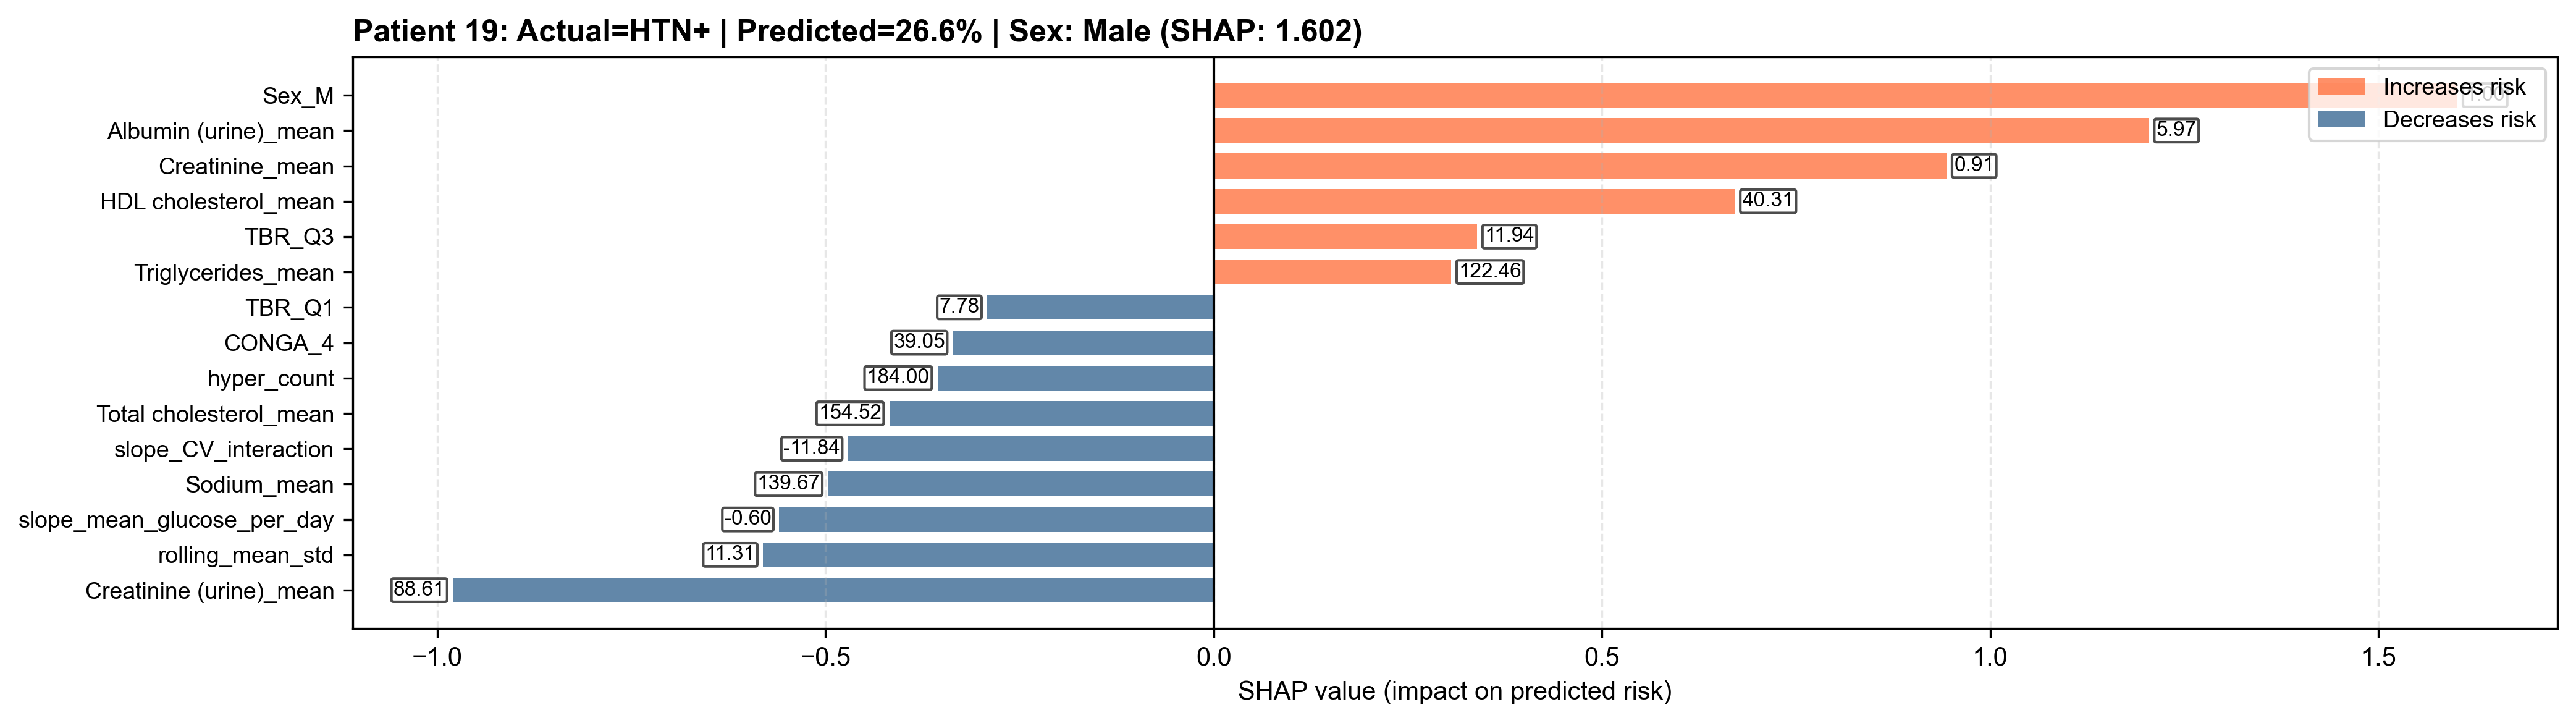


DETAILED PATIENT INSIGHTS

PATIENT 1: Index 19
• Predicted hypertension risk: 26.58%
• Actual outcome: Hypertensive (False Negative)
• Sex: Male (SHAP: 1.6015)

TOP PROTECTIVE FACTORS (reduced risk):
  • Creatinine (urine)_mean: 88.61 (↓) → SHAP: -0.9801
  • rolling_mean_std: 11.31 (↓) → SHAP: -0.5806
  • slope_mean_glucose_per_day: -0.60 (↓) → SHAP: -0.5599
  • Sodium_mean: 139.67 (↓) → SHAP: -0.4969
  • slope_CV_interaction: -11.84 (↓) → SHAP: -0.4713

TOP RISK FACTORS (increased risk):
  • Sex_M: 1.00 (↓) → SHAP: 1.6015
  • Albumin (urine)_mean: 5.97 (↓) → SHAP: 1.2040
  • Creatinine_mean: 0.91 (↓) → SHAP: 0.9435
  • HDL cholesterol_mean: 40.31 (↓) → SHAP: 0.6708
  • TBR_Q3: 11.94 (↓) → SHAP: 0.3387

COUNTERFACTUAL INSIGHT:
  If Creatinine (urine)_mean were at median level, 
  predicted risk would increase by ~0.980

SUMMARY STATISTICS FOR SELECTED PATIENTS
 Patient_Index  Predicted_Risk  Mean_Protective_SHAP  Mean_Risk_SHAP
            19        0.265767             -0.239777     

In [70]:
# Set random seed for reproducibility
#RANDOM_SEED = 100

# Run counterfactual analysis
#selected_cases, summary_df = counterfactual_analysis_misclassified(
#    model=model,
#    X_test=X_test,
#    y_test=y_test,
#    y_pred_proba=y_pred_proba,
#    shap_values=shap_values_hypertension,
#    feature_names=feature_names,
#    n_examples=5,
#    threshold=0.5,
#    random_state=RANDOM_SEED,  # Set seed here
#    save_path='figures/counterfactual_analysis.png'
#)

In [37]:
def deep_dive_false_negatives(
    model,
    X_test,
    y_test,
    y_pred_proba,
    shap_values,
    feature_names,
    threshold=0.3,
    n_patients=None
):
    """
    Comprehensive analysis of ALL false negative cases
    """
    
    false_negatives = (y_test == 1) & (y_pred_proba < threshold)
    fn_indices = np.where(false_negatives)[0]
    
    if len(fn_indices) == 0:
        print(f"No false negatives found at threshold {threshold}")
        return []
    
    print("=" * 70)
    print(f"DEEP DIVE: {len(fn_indices)} FALSE NEGATIVE PATIENTS")
    print("=" * 70)
    
    # Convert to DataFrame
    if not hasattr(X_test, "iloc"):
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
    else:
        X_test_df = X_test.copy()
        if hasattr(X_test, 'columns'):
            X_test_df.columns = feature_names
    
    # Limit number of patients if specified
    if n_patients is not None and len(fn_indices) > n_patients:
        print(f"Analyzing first {n_patients} of {len(fn_indices)} false negatives")
        fn_indices = fn_indices[:n_patients]
    
    all_comparisons = []
    
    # Analyze each false negative patient
    for patient_num, fn_idx in enumerate(fn_indices, 1):
        print(f"\n{'='*60}")
        print(f"PATIENT {patient_num} OF {len(fn_indices)}: Index {fn_idx}")
        print(f"{'='*60}")
        
        patient_shap = shap_values[fn_idx]
        patient_features = X_test_df.iloc[fn_idx]
        
        # 1. Basic info
        print(f"\n📋 PATIENT PROFILE:")
        print(f"   Index: {fn_idx}")
        print(f"   Predicted risk: {y_pred_proba[fn_idx]:.2%}")
        print(f"   Actual: Hypertensive")
        
        # 2. Comparison to typical hypertensive patient
        htn_indices = np.where(y_test == 1)[0]
        typical_htn_features = X_test_df.iloc[htn_indices].median()
        
        print(f"\n📊 HOW THIS PATIENT DIFFERS FROM TYPICAL HYPERTENSIVE:")
        
        df_comparison = pd.DataFrame({
            'Feature': feature_names,
            'This_Patient': patient_features.values,
            'Typical_Hypertensive': typical_htn_features.values,
            'Difference': patient_features.values - typical_htn_features.values,
            'SHAP': patient_shap,
            'Patient_Index': fn_idx
        })
        
        # Sort by absolute difference
        df_comparison['abs_diff'] = np.abs(df_comparison['Difference'])
        top_diff = df_comparison.sort_values('abs_diff', ascending=False).head(10)
        
        for _, row in top_diff.iterrows():
            direction = "↑" if row['Difference'] > 0 else "↓"
            print(f"   • {row['Feature']}: {row['This_Patient']:.2f} "
                  f"({direction}{abs(row['Difference']):.2f} from typical)")
        
        # 3. SHAP waterfall explanation
        print(f"\n🎯 SHAP WATERFALL EXPLANATION:")
        
        df_shap = pd.DataFrame({
            'Feature': feature_names,
            'SHAP': patient_shap,
            'Value': patient_features.values
        }).sort_values('SHAP', ascending=False)
        
        # Positive contributors
        positive = df_shap[df_shap['SHAP'] > 0].head(5)
        if len(positive) > 0:
            print(f"   Factors INCREASING risk:")
            for _, row in positive.iterrows():
                print(f"     + {row['Feature']} = {row['Value']:.2f} "
                      f"(contribution: +{row['SHAP']:.3f})")
        
        # Negative contributors
        negative = df_shap[df_shap['SHAP'] < 0].head(5)
        if len(negative) > 0:
            print(f"\n   Factors DECREASING risk:")
            for _, row in negative.iterrows():
                print(f"     - {row['Feature']} = {row['Value']:.2f} "
                      f"(contribution: {row['SHAP']:.3f})")
        
        # 4. Counterfactual scenarios
        print(f"\n🔮 COUNTERFACTUAL SCENARIOS:")
        
        # What if protective factors were at median levels?
        median_values = X_test_df.median()
        protective_factors = df_shap[df_shap['SHAP'] < 0].head(3)
        
        for _, row in protective_factors.iterrows():
            feat = row['Feature']
            current = row['Value']
            median = median_values[feat]
            shap_effect = row['SHAP']
            
            if current != median:
                print(f"   If {feat} were at median ({median:.2f}) instead of {current:.2f}:")
                print(f"     Risk would increase by ~{abs(shap_effect):.3f}")
                print(f"     New predicted risk: ~{y_pred_proba[fn_idx] - shap_effect:.1%}")
        
        # 5. Clinical recommendations
        print(f"\n💡 CLINICAL INSIGHTS:")
        
        # Identify modifiable risk/protective factors
        modifiable_keywords = ['glucose', 'cholesterol', 'bmi', 'weight', 
                              'activity', 'diet', 'pressure', 'lipid', 'hdl', 'ldl']
        
        modifiable_found = False
        for _, row in df_shap.iterrows():
            feat = row['Feature'].lower()
            if any(keyword in feat for keyword in modifiable_keywords):
                if row['SHAP'] < -0.1:  # Strong protective effect
                    print(f"   • {row['Feature']} is strongly protective ({row['SHAP']:.3f})")
                    print(f"     Consider maintaining current level: {row['Value']:.2f}")
                    modifiable_found = True
                elif row['SHAP'] > 0.1:  # Strong risk factor
                    print(f"   • {row['Feature']} increases risk ({row['SHAP']:.3f})")
                    print(f"     Current: {row['Value']:.2f} - monitor closely")
                    modifiable_found = True
        
        if not modifiable_found:
            print(f"   No strong modifiable risk/protective factors identified")
        
        all_comparisons.append(df_comparison)
    
    # ============================================================
    # ADDED: Comparative analysis across all false negatives
    # ============================================================
    if len(fn_indices) > 1:
        print(f"\n{'='*70}")
        print(f"COMPARATIVE ANALYSIS ACROSS {len(fn_indices)} FALSE NEGATIVES")
        print(f"{'='*70}")
        
        # Calculate average characteristics
        avg_predicted_risk = y_pred_proba[fn_indices].mean()
        avg_actual_risk = 1.0  # All are hypertensive
        avg_male_percentage = X_test_df.iloc[fn_indices]['Sex_M'].mean() if 'Sex_M' in X_test_df.columns else "N/A"
        
        print(f"\n📈 SUMMARY STATISTICS:")
        print(f"   Number of false negatives: {len(fn_indices)}")
        print(f"   Average predicted risk: {avg_predicted_risk:.2%}")
        print(f"   Actual risk: 100% (all hypertensive)")
        print(f"   Male percentage: {avg_male_percentage:.1%}" if isinstance(avg_male_percentage, (int, float)) else f"   Sex data: {avg_male_percentage}")
        
        # Find common protective factors across patients
        common_protective = {}
        common_risk = {}
        
        for idx in fn_indices:
            patient_shap = shap_values[idx]
            for feat_idx, shap_val in enumerate(patient_shap):
                feat_name = feature_names[feat_idx]
                if shap_val < -0.1:  # Protective
                    common_protective[feat_name] = common_protective.get(feat_name, 0) + 1
                elif shap_val > 0.1:  # Risk factor
                    common_risk[feat_name] = common_risk.get(feat_name, 0) + 1
        
        if common_protective:
            print(f"\n🛡️  COMMON PROTECTIVE FACTORS (across {len(fn_indices)} patients):")
            sorted_protective = sorted(common_protective.items(), key=lambda x: x[1], reverse=True)[:5]
            for feat, count in sorted_protective:
                percentage = (count / len(fn_indices)) * 100
                print(f"   • {feat}: {count}/{len(fn_indices)} patients ({percentage:.0f}%)")
        
        if common_risk:
            print(f"\n⚠️  COMMON RISK FACTORS (across {len(fn_indices)} patients):")
            sorted_risk = sorted(common_risk.items(), key=lambda x: x[1], reverse=True)[:5]
            for feat, count in sorted_risk:
                percentage = (count / len(fn_indices)) * 100
                print(f"   • {feat}: {count}/{len(fn_indices)} patients ({percentage:.0f}%)")
        
        # Calculate how different they are from each other
        print(f"\n🔍 PATIENT SIMILARITY ANALYSIS:")
        fn_features = X_test_df.iloc[fn_indices].values
        
        if len(fn_indices) > 1:
            from scipy.spatial.distance import pdist, squareform
            distances = pdist(fn_features, metric='euclidean')
            avg_distance = distances.mean()
            min_distance = distances.min()
            max_distance = distances.max()
            
            print(f"   Average Euclidean distance between patients: {avg_distance:.2f}")
            print(f"   Minimum distance (most similar pair): {min_distance:.2f}")
            print(f"   Maximum distance (most different pair): {max_distance:.2f}")
            
            if avg_distance < X_test_df.std().mean() * 2:
                print(f"   → Patients are relatively similar to each other")
            else:
                print(f"   → Patients are relatively diverse")
        
        # Create summary table
        print(f"\n📋 PATIENT SUMMARY TABLE:")
        summary_data = []
        for i, idx in enumerate(fn_indices, 1):
            patient_shap = shap_values[idx]
            protective_count = np.sum(patient_shap < -0.1)
            risk_count = np.sum(patient_shap > 0.1)
            strongest_protective_idx = np.argmin(patient_shap)
            strongest_risk_idx = np.argmax(patient_shap)
            
            summary_data.append({
                'Patient': i,
                'Index': idx,
                'Pred_Risk': f"{y_pred_proba[idx]:.1%}",
                'Protective_Factors': protective_count,
                'Risk_Factors': risk_count,
                'Strongest_Protective': feature_names[strongest_protective_idx],
                'Strongest_Risk': feature_names[strongest_risk_idx]
            })
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
    
    return all_comparisons

all_comparisons = deep_dive_false_negatives(
    model=model,
    X_test=X_test,
    y_test=y_test,
    y_pred_proba=y_pred_proba,
    shap_values=shap_values_hypertension,
    feature_names=feature_names,
    threshold=0.3,
    n_patients=None  # Set to 3 if you only want first 3
)

DEEP DIVE: 3 FALSE NEGATIVE PATIENTS

PATIENT 1 OF 3: Index 6

📋 PATIENT PROFILE:
   Index: 6
   Predicted risk: 1.65%
   Actual: Hypertensive

📊 HOW THIS PATIENT DIFFERS FROM TYPICAL HYPERTENSIVE:
   • Sodium_mean: -2.13 (↓2.89 from typical)
   • TBR_day: 1.37 (↑1.11 from typical)
   • CV_day: 1.36 (↑1.10 from typical)
   • TIR_Q2: 0.89 (↑1.01 from typical)
   • Sex_M: 1.03 (↑1.00 from typical)
   • TBR_Q2: 1.00 (↑0.99 from typical)
   • TIR_Q1: 0.75 (↑0.86 from typical)
   • TBR_Q4: 0.57 (↑0.71 from typical)
   • TIR_night: 1.05 (↑0.65 from typical)
   • Creatinine (urine)_mean: -1.23 (↓0.64 from typical)

🎯 SHAP WATERFALL EXPLANATION:
   Factors INCREASING risk:
     + Age = 1.28 (contribution: +1.204)
     + Number_of_biochemical_parameters = 0.03 (contribution: +0.783)
     + Creatinine (urine)_mean = -1.23 (contribution: +0.530)
     + slope_mean_glucose_per_day = 0.21 (contribution: +0.411)
     + slope_TIR_per_day = -0.44 (contribution: +0.333)

   Factors DECREASING risk:
    

In [36]:
# Run the deep dive analysis
#df_comparison = deep_dive_single_false_negative(
#    model=model,                    # Your trained model
#    X_test=X_test,                  # Your test features
#    y_test=y_test,                  # Your test labels
#    y_pred_proba=y_pred_proba,      # Predicted probabilities
#    shap_values=shap_values_hypertension,  # SHAP values for hypertension class
#    feature_names=feature_names,    # List of feature names
#    threshold=0.3                   # Same threshold you used before
#)

DEEP DIVE: SINGLE FALSE NEGATIVE PATIENT

📋 PATIENT PROFILE:
   Index: 6
   Predicted risk: 1.65%
   Actual: Hypertensive

HOW THIS PATIENT DIFFERS FROM TYPICAL HYPERTENSIVE:
   • Sodium_mean: -2.13 (↓2.89 from typical)
   • TBR_day: 1.37 (↑1.11 from typical)
   • CV_day: 1.36 (↑1.10 from typical)
   • TIR_Q2: 0.89 (↑1.01 from typical)
   • Sex_M: 1.03 (↑1.00 from typical)
   • TBR_Q2: 1.00 (↑0.99 from typical)
   • TIR_Q1: 0.75 (↑0.86 from typical)
   • TBR_Q4: 0.57 (↑0.71 from typical)
   • TIR_night: 1.05 (↑0.65 from typical)
   • Creatinine (urine)_mean: -1.23 (↓0.64 from typical)

SHAP WATERFALL EXPLANATION:
   Factors INCREASING risk:
     + Age = 1.28 (contribution: +1.204)
     + Number_of_biochemical_parameters = 0.03 (contribution: +0.783)
     + Creatinine (urine)_mean = -1.23 (contribution: +0.530)
     + slope_mean_glucose_per_day = 0.21 (contribution: +0.411)
     + slope_TIR_per_day = -0.44 (contribution: +0.333)

   Factors DECREASING risk:
     - TBR_day = 1.37 (contri

In [38]:
# ==============================================================================
# SUBGROUP ANALYSIS
# ==============================================================================

# Make a clean copy without adding columns to original df
df_analysis = df_complete.copy()

# Remove Age_Group if it exists (from previous runs)
if 'Age_Group' in df_analysis.columns:
    df_analysis = df_analysis.drop(columns=['Age_Group'])
if 'HbA1c_Control' in df_analysis.columns:
    df_analysis = df_analysis.drop(columns=['HbA1c_Control'])

# ------------------------------------------------------------------------------
# Helper function to prepare data
# ------------------------------------------------------------------------------
def prepare_subgroup_data(df, subgroup_col, subgroup_value, cols_to_drop):
    """Filter and clean data for subgroup analysis"""
    df_subset = df[df[subgroup_col] == subgroup_value].copy()
    # Drop the grouping columns before analysis
    df_subset = df_subset.drop(columns=cols_to_drop, errors='ignore')
    return df_subset

# ------------------------------------------------------------------------------
# Setup
# ------------------------------------------------------------------------------

subgroup_results = {
    'age': {},
    'sex': {},
    'hba1c': {}
}

# ------------------------------------------------------------------------------
# AGE SUBGROUPS
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("AGE SUBGROUP ANALYSIS")
print("="*80 + "\n")

# Create age groups temporarily
df_age = df_complete.copy()
df_age['Age_Group'] = df_age['Age'].apply(lambda x: '<40' if x < 40 else '>=40')
print(f"Age group distribution:\n{df_age['Age_Group'].value_counts()}\n")

for age_group in ['<40', '>=40']:
    print(f"\n{'*'*60}")
    print(f"Analyzing: Age {age_group}")
    print(f"{'*'*60}")
    
    df_age_subset = prepare_subgroup_data(df_age, 'Age_Group', age_group, ['Age_Group'])
    
    n_pos = int(df_age_subset[condition].sum())
    print(f"Subset size: {len(df_age_subset)}")
    print(f"Positive cases: {n_pos}")
    
    # Skip if insufficient samples - need at least 10 positive for SMOTE
    if len(df_age_subset) < 20 or n_pos < 10:
        print(f"WARNING: Insufficient positive cases (need >=10, have {n_pos}), skipping...")
        continue
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_age_subset,
                target_col=condition,
                n_splits=min(10, n_pos),  # Adjust folds based on positive cases
                random_state=seed
            )
            
            if seed not in subgroup_results['age']:
                subgroup_results['age'][seed] = {}
            
            subgroup_results['age'][seed][age_group] = {
                'results': results,
                'n_samples': len(df_age_subset),
                'n_positive': n_pos
            }
            
            print(f"\nSeed {seed} - Age {age_group}:")
            print(f"  ROC-AUC With CGM:    {np.mean(results['with_cgm']['roc_auc']):.3f} ± {np.std(results['with_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(results['without_cgm']['roc_auc']):.3f} ± {np.std(results['without_cgm']['roc_auc']):.3f}")
            delta = np.mean(results['with_cgm']['roc_auc']) - np.mean(results['without_cgm']['roc_auc'])
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")

# ------------------------------------------------------------------------------
# SEX SUBGROUPS
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("SEX SUBGROUP ANALYSIS")
print("="*80 + "\n")

print(f"Sex distribution:\n{df_complete['Sex'].value_counts()}\n")

for sex in df_analysis['Sex'].unique():
    print(f"\n{'*'*60}")
    print(f"Analyzing: Sex = {sex}")
    print(f"{'*'*60}")
    
    # Use df_complete (not df_analysis which might have Age_Group)
    df_sex_subset = df_analysis[df_analysis['Sex'] == sex].copy()
    
    n_pos = int(df_sex_subset[condition].sum())
    print(f"Subset size: {len(df_sex_subset)}")
    print(f"Positive cases: {n_pos}")
    
    if len(df_sex_subset) < 20 or n_pos < 5:
        print("WARNING: Insufficient samples, skipping...")
        continue
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_sex_subset,
                target_col=condition,
                n_splits=min(10, n_pos),
                random_state=seed
            )
            
            if seed not in subgroup_results['sex']:
                subgroup_results['sex'][seed] = {}
            
            subgroup_results['sex'][seed][sex] = {
                'results': results,
                'n_samples': len(df_sex_subset),
                'n_positive': n_pos
            }
            
            print(f"\nSeed {seed} - Sex {sex}:")
            print(f"  ROC-AUC Combined:    {np.mean(results['with_cgm']['roc_auc']):.3f} ± {np.std(results['with_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Biochemical: {np.mean(results['without_cgm']['roc_auc']):.3f} ± {np.std(results['without_cgm']['roc_auc']):.3f}")
            delta = np.mean(results['with_cgm']['roc_auc']) - np.mean(results['without_cgm']['roc_auc'])
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")
            
# ------------------------------------------------------------------------------
# HbA1c CONTROL SUBGROUPS
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("HbA1c CONTROL SUBGROUP ANALYSIS")
print("="*80 + "\n")

# Create HbA1c groups
df_hba1c = df_analysis.dropna(subset=['A1c_mean']).copy()
df_hba1c['HbA1c_Control'] = df_hba1c['A1c_mean'].apply(
    lambda x: 'Good (<7.5%)' if x < 7.5 else 'Poor (>=7.5%)'
)
print(f"HbA1c control distribution:\n{df_hba1c['HbA1c_Control'].value_counts()}\n")

for hba1c_group in ['Good (<7.5%)', 'Poor (>=7.5%)']:
    print(f"\n{'*'*60}")
    print(f"Analyzing: HbA1c Control = {hba1c_group}")
    print(f"{'*'*60}")
    
    df_hba1c_subset = prepare_subgroup_data(df_hba1c, 'HbA1c_Control', hba1c_group, ['HbA1c_Control'])
    
    n_pos = int(df_hba1c_subset[condition].sum())
    print(f"Subset size: {len(df_hba1c_subset)}")
    print(f"Positive cases: {n_pos}")
    
    if len(df_hba1c_subset) < 20 or n_pos < 5:
        print("WARNING: Insufficient samples, skipping...")
        continue
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_hba1c_subset,
                target_col=condition,
                n_splits=min(10, n_pos),
                random_state=seed
            )
            
            if seed not in subgroup_results['hba1c']:
                subgroup_results['hba1c'][seed] = {}
            
            subgroup_results['hba1c'][seed][hba1c_group] = {
                'results': results,
                'n_samples': len(df_hba1c_subset),
                'n_positive': n_pos
            }
            
            print(f"\nSeed {seed} - HbA1c {hba1c_group}:")
            print(f"  ROC-AUC With CGM:    {np.mean(results['with_cgm']['roc_auc']):.3f} ± {np.std(results['with_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(results['without_cgm']['roc_auc']):.3f} ± {np.std(results['without_cgm']['roc_auc']):.3f}")
            delta = np.mean(results['with_cgm']['roc_auc']) - np.mean(results['without_cgm']['roc_auc'])
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")

# ------------------------------------------------------------------------------
# SUMMARY TABLE
# ------------------------------------------------------------------------------

print("\n\n" + "="*100)
print("SUMMARY TABLE - SUBGROUP ANALYSIS")
print("="*100 + "\n")

summary_rows = []

for analysis_type in ['age', 'sex', 'hba1c']:
    for seed in seeds:
        if seed not in subgroup_results[analysis_type]:
            continue
            
        for subgroup_name, data in subgroup_results[analysis_type][seed].items():
            results = data['results']
            
            row = {
                'Analysis': analysis_type.upper(),
                'Subgroup': subgroup_name,
                'N': data['n_samples'],
                'N_pos': data['n_positive'],
                'Prev_%': f"{(data['n_positive']/data['n_samples']*100):.1f}",
                'AUC_with': f"{np.mean(results['with_cgm']['roc_auc']):.3f}±{np.std(results['with_cgm']['roc_auc']):.3f}",
                'AUC_without': f"{np.mean(results['without_cgm']['roc_auc']):.3f}±{np.std(results['without_cgm']['roc_auc']):.3f}",
                'AUC_only': f"{np.mean(results['only_cgm']['roc_auc']):.3f}±{np.std(results['only_cgm']['roc_auc']):.3f}",
                'Delta_AUC': f"{(np.mean(results['with_cgm']['roc_auc']) - np.mean(results['without_cgm']['roc_auc'])):.3f}",
                'Rel_Impr_%': f"{((np.mean(results['with_cgm']['roc_auc']) - np.mean(results['without_cgm']['roc_auc'])) / np.mean(results['without_cgm']['roc_auc']) * 100):.1f}",
            }
            summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

# Save results
import pickle
with open(f'subgroup_results_{condition}.pkl', 'wb') as f:
    pickle.dump(subgroup_results, f)
print(f"\n\nResults saved to: subgroup_results_{condition}.pkl")

summary_df.to_csv(f'subgroup_summary_{condition}.csv', index=False)
print(f"Summary table saved to: subgroup_summary_{condition}.csv")


AGE SUBGROUP ANALYSIS

Age group distribution:
Age_Group
>=40    372
<40     317
Name: count, dtype: int64


************************************************************
Analyzing: Age <40
************************************************************
Subset size: 317
Positive cases: 5

************************************************************
Analyzing: Age >=40
************************************************************
Subset size: 372
Positive cases: 62
Fold  1: With=0.641, Without=0.733, Only=0.281
Fold  2: With=0.673, Without=0.631, Only=0.562
Fold  3: With=0.656, Without=0.554, Only=0.699
Fold  4: With=0.683, Without=0.699, Only=0.505
Fold  5: With=0.527, Without=0.597, Only=0.398
Fold  6: With=0.763, Without=0.758, Only=0.398
Fold  7: With=0.790, Without=0.651, Only=0.667
Fold  8: With=0.554, Without=0.790, Only=0.237
Fold  9: With=0.667, Without=0.656, Only=0.780
Fold 10: With=0.651, Without=0.763, Only=0.559

Seed 42 - Age >=40:
  ROC-AUC With CGM:    0.660 ± 0.076
  ROC-A

Creating comparison plot...
Plot saved as: subgroup_analysis_Hypertension.png


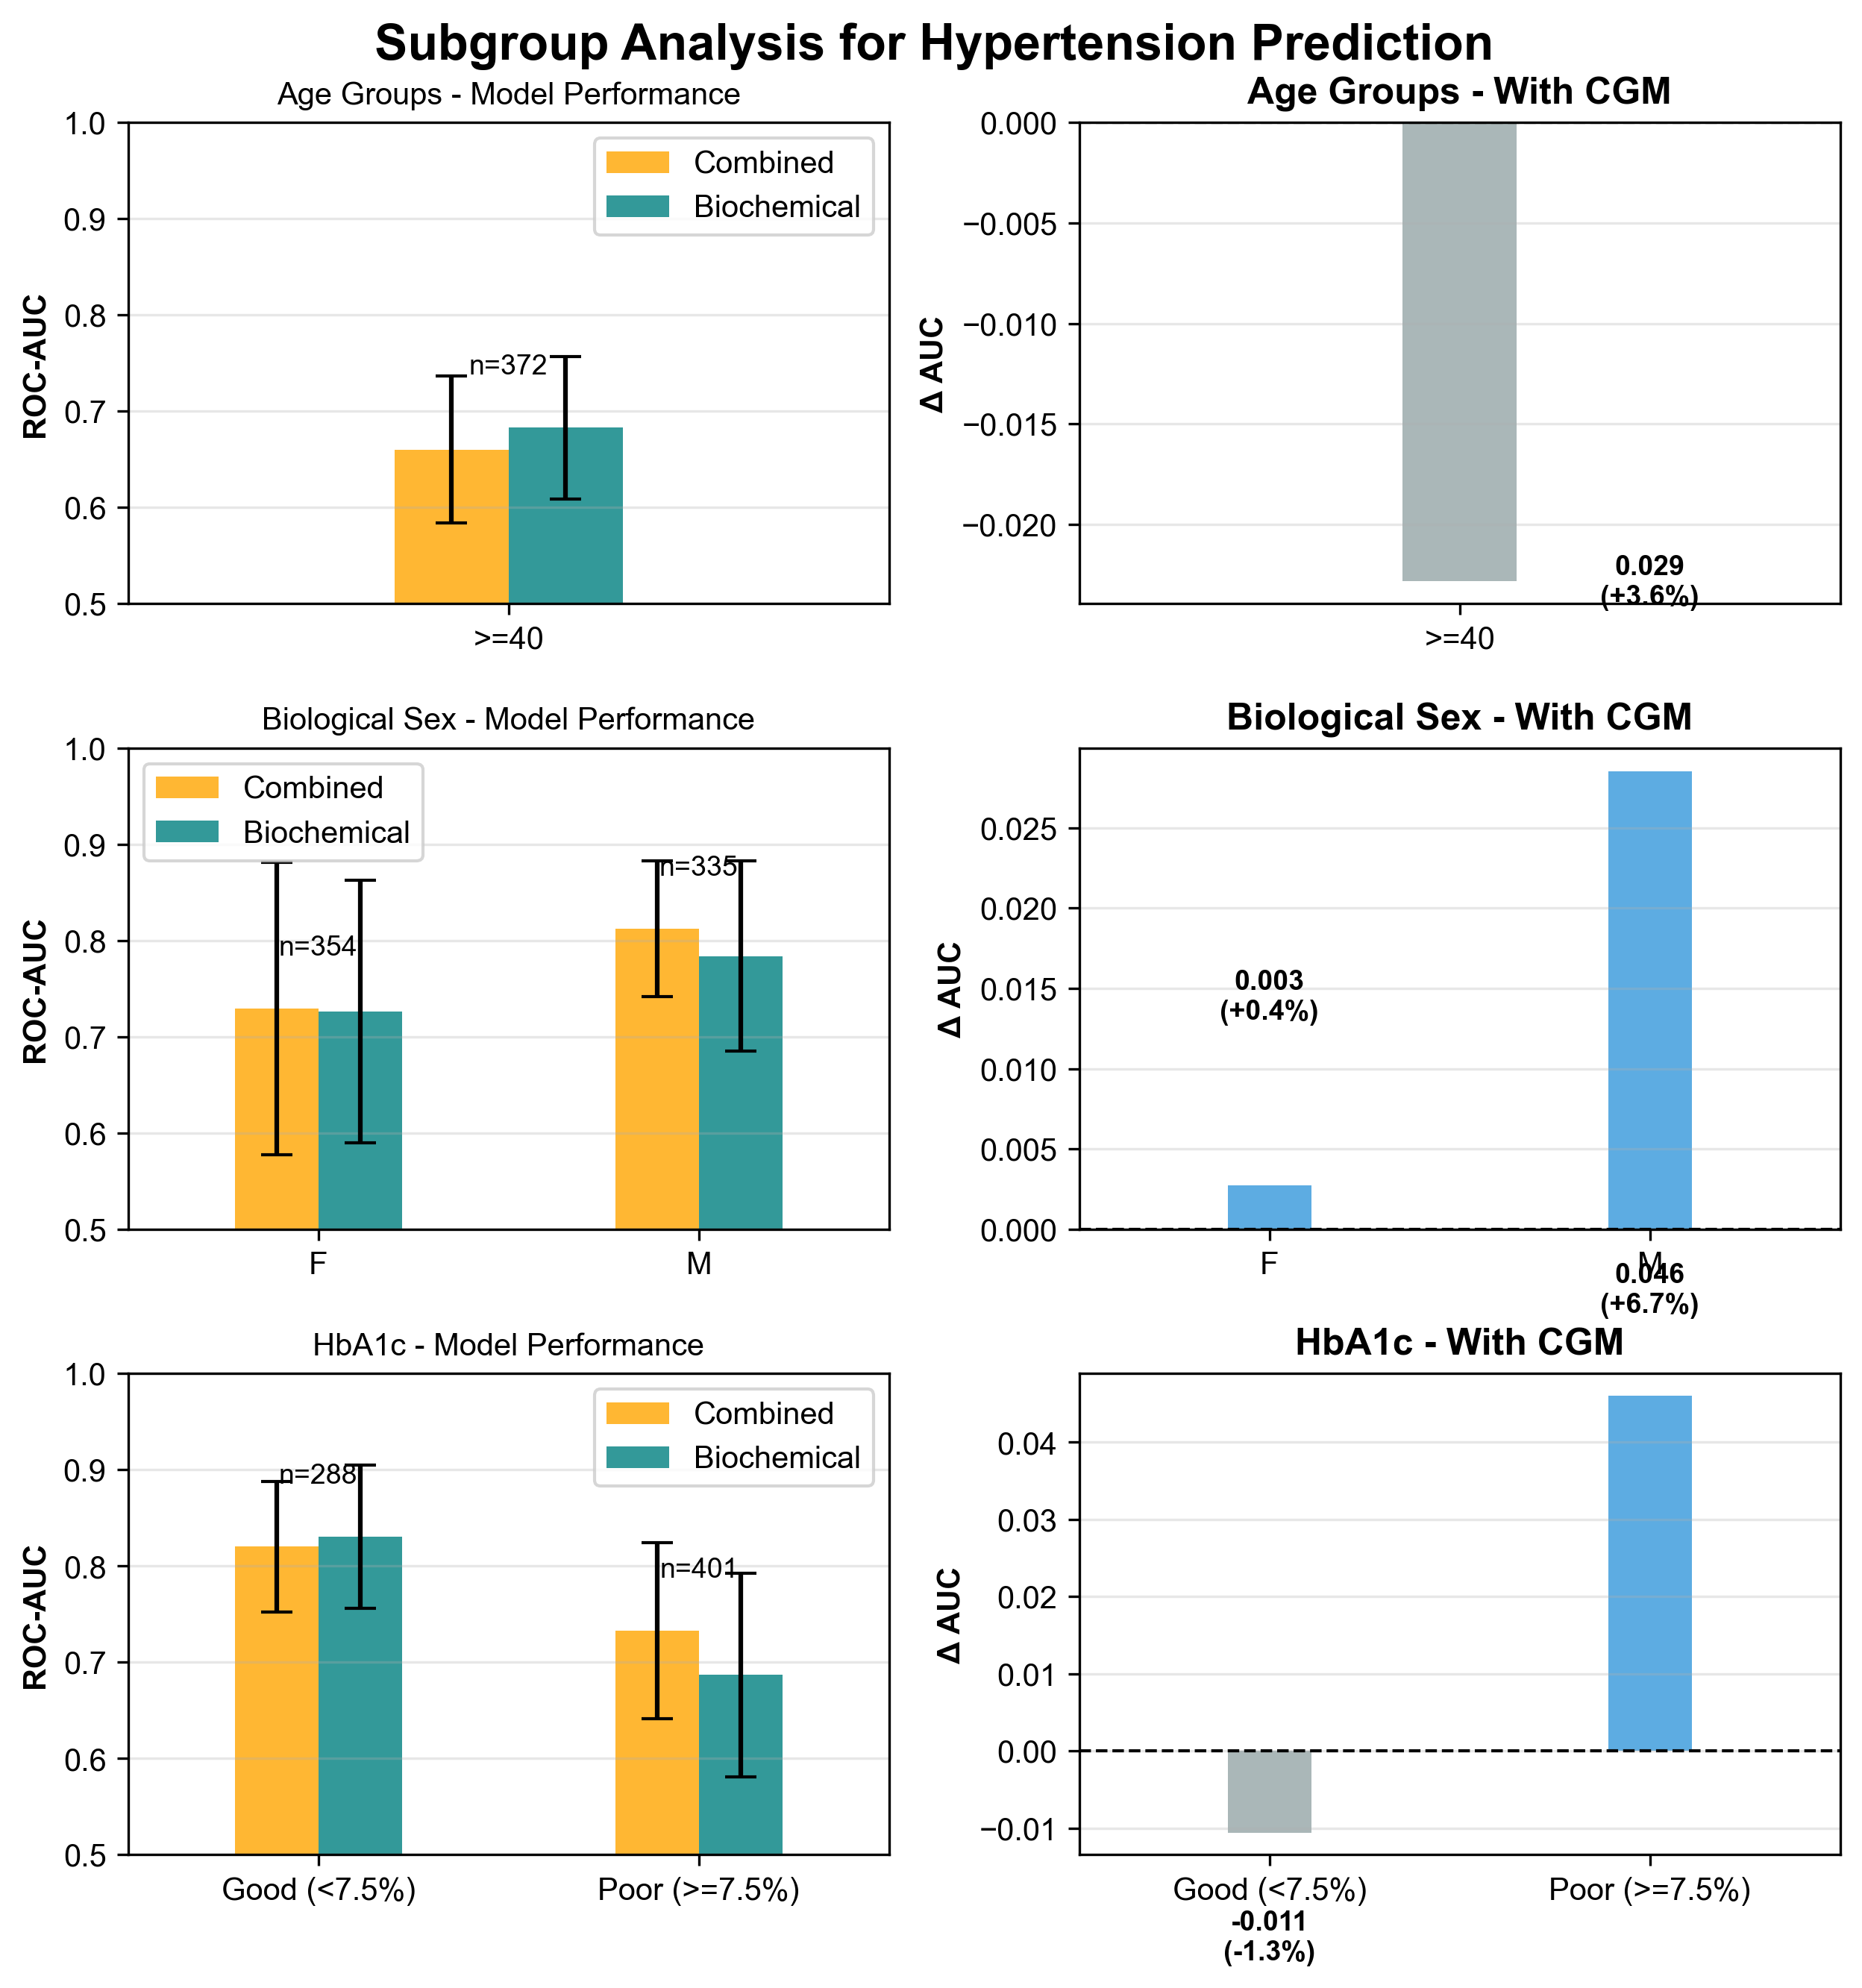


Creating forest plot...
Forest plot saved as: forest_plot_Hypertension.png


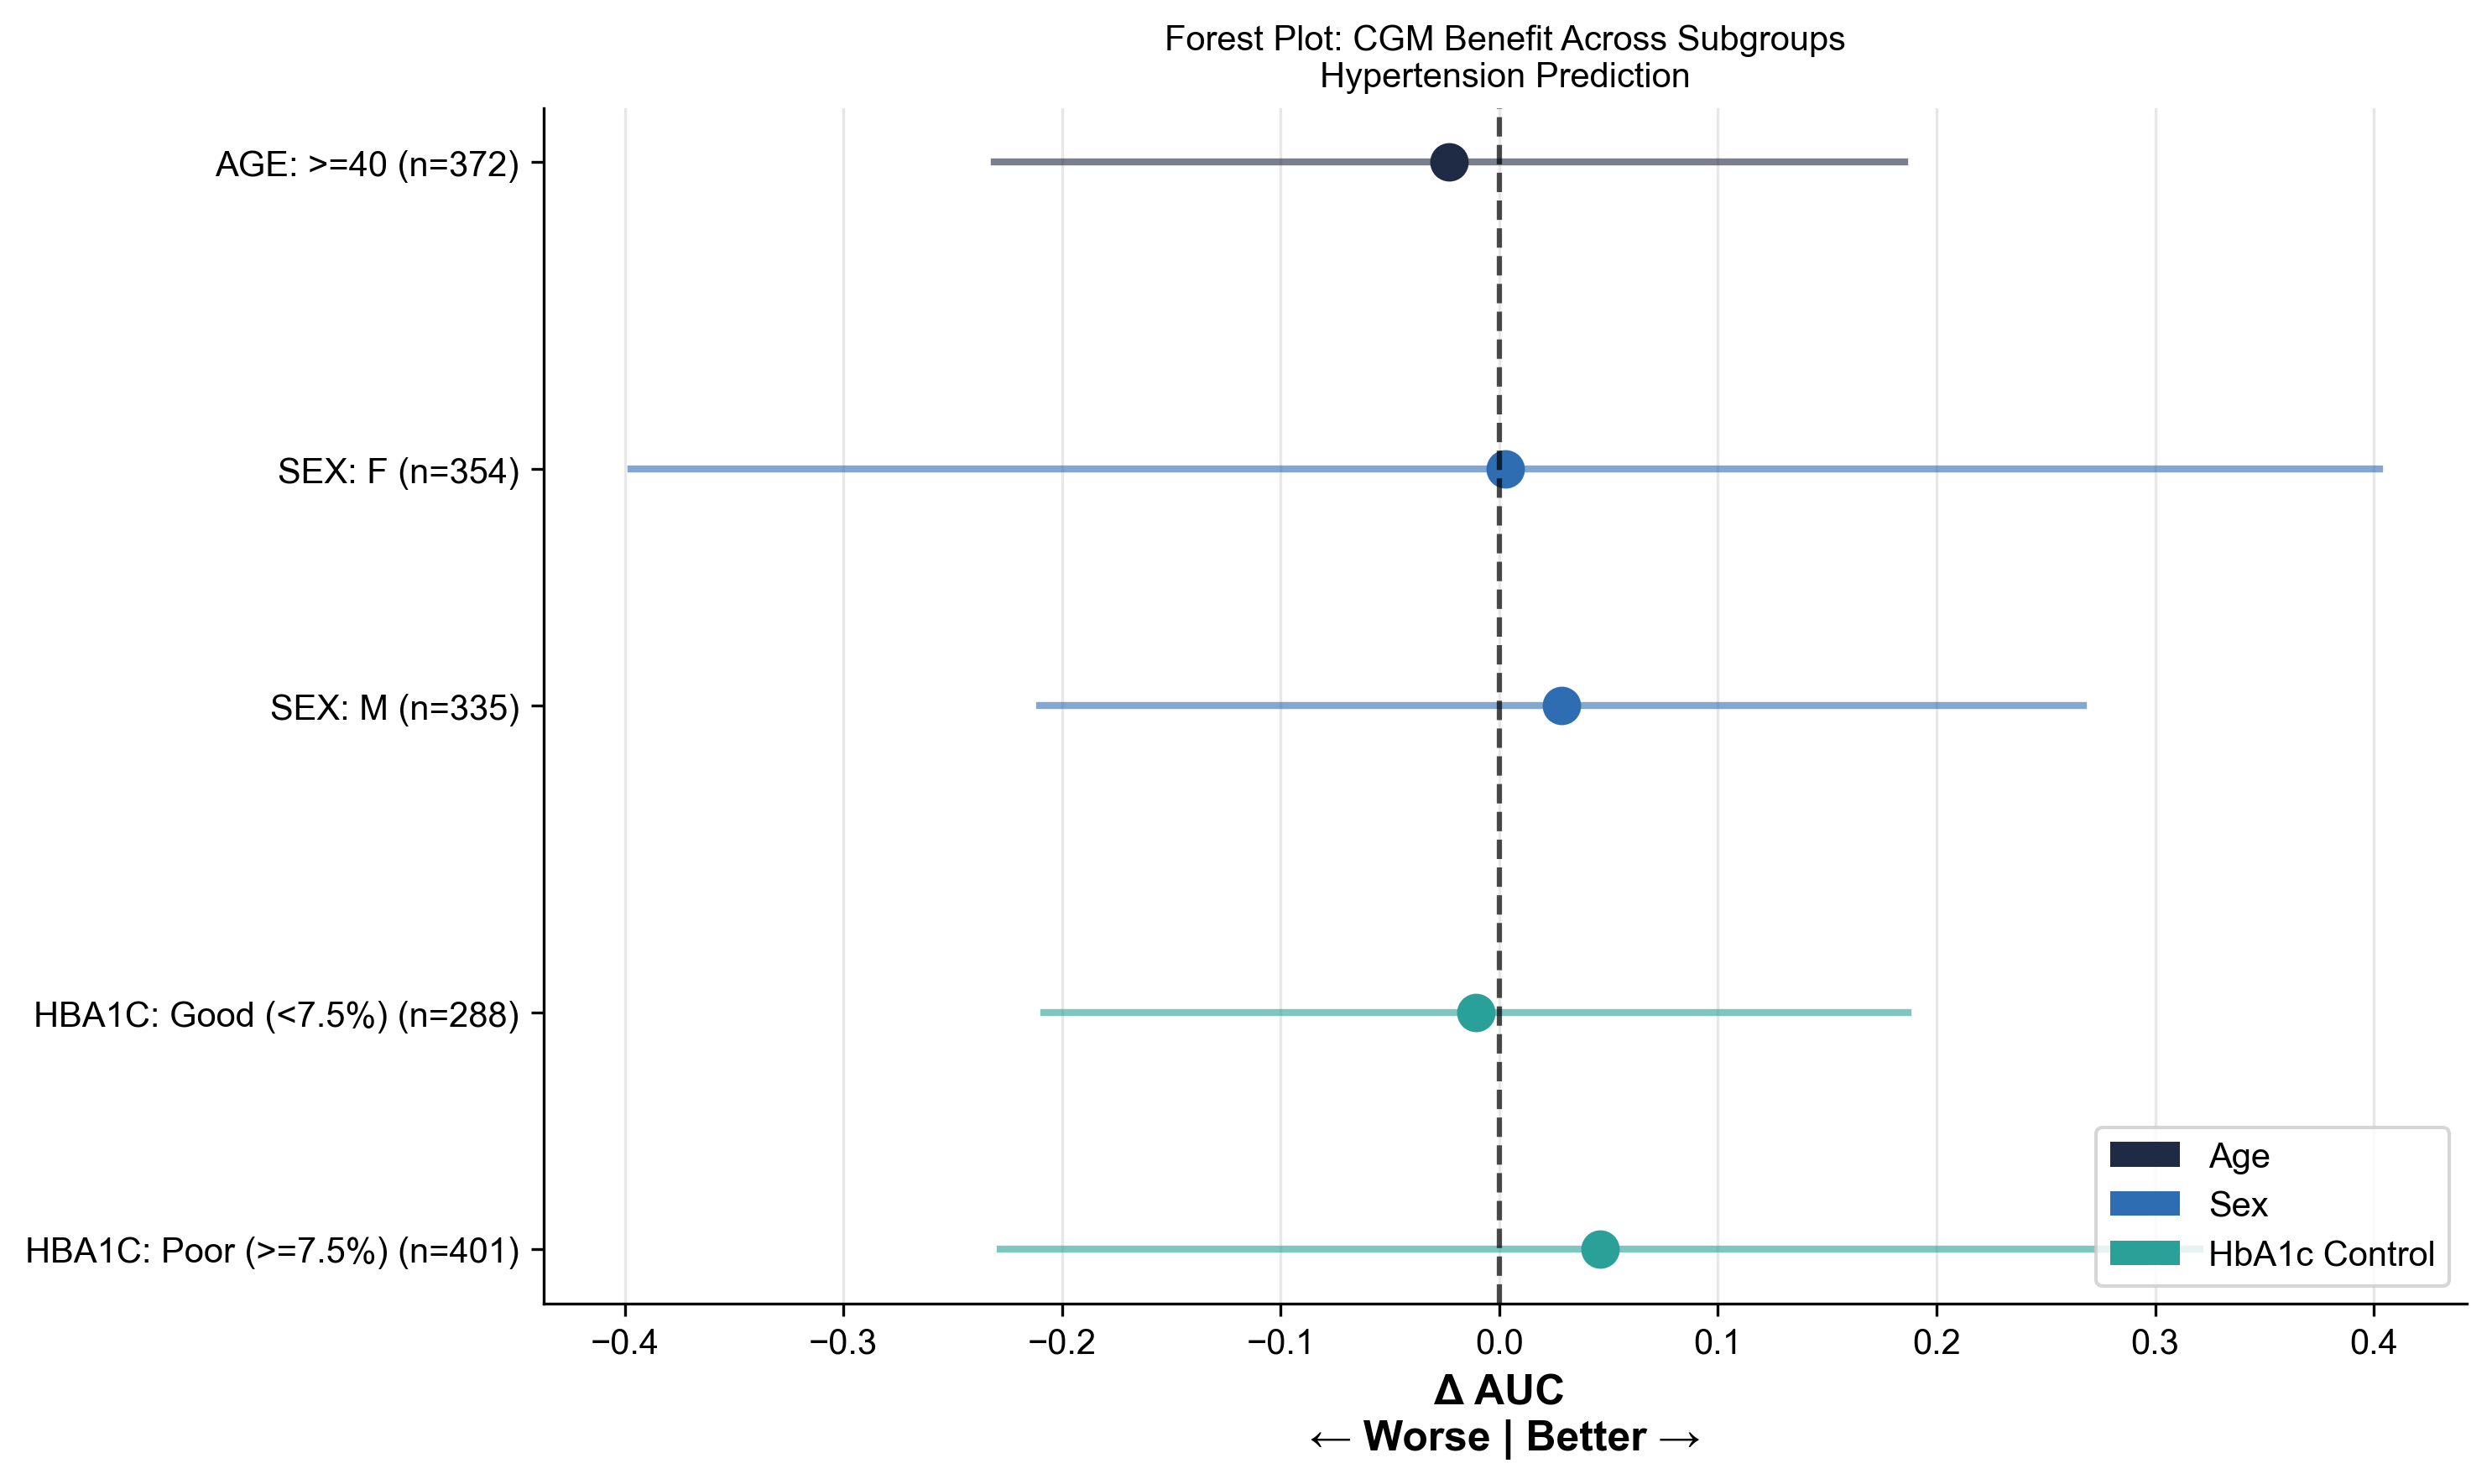


✓ All visualizations complete!


In [39]:
# ==============================================================================
# VISUALIZATION CODE FOR SUBGROUP ANALYSIS
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
arial = FontProperties(family='Arial')
import matplotlib as mpl

def plot_subgroup_comparison(subgroup_results, condition='Hypertension', seed=42):
    """
    Create comparison plots for all subgroup analyses.
    
    Shows AUC with/without CGM and the benefit of adding CGM for each subgroup.
    """
    with mpl.rc_context({'font.family': 'Arial'}): 
        fig, axes = plt.subplots(3, 2, figsize=(9, 9))
        fig.suptitle(f'Subgroup Analysis for {condition} Prediction', fontsize=16, fontweight='bold', fontproperties=arial)
        
        analysis_types = ['age', 'sex', 'hba1c']
        analysis_names = ['Age Groups', 'Biological Sex', 'HbA1c']
        
        for idx, (analysis_type, analysis_name) in enumerate(zip(analysis_types, analysis_names)):
            
            if seed not in subgroup_results[analysis_type] or not subgroup_results[analysis_type][seed]:
                continue
            
            # Prepare data
            subgroups = []
            auc_with = []
            auc_without = []
            auc_with_std = []
            auc_without_std = []
            n_samples = []
            
            for subgroup_name, data in subgroup_results[analysis_type][seed].items():
                results = data['results']
                subgroups.append(subgroup_name)
                auc_with.append(np.mean(results['with_cgm']['roc_auc']))
                auc_without.append(np.mean(results['without_cgm']['roc_auc']))
                auc_with_std.append(np.std(results['with_cgm']['roc_auc']))
                auc_without_std.append(np.std(results['without_cgm']['roc_auc']))
                n_samples.append(data['n_samples'])
            
            # Plot 1: AUC comparison
            ax1 = axes[idx, 0]
            x = np.arange(len(subgroups))
            n_groups = len(subgroups)
    
            if n_groups == 1:
                width = 0.15
            else:
                width = 0.22
            
            bars1 = ax1.bar(x - width/2, auc_with, width, label='Combined', 
                            yerr=auc_with_std, capsize=5, alpha=0.8, color='orange')
            bars2 = ax1.bar(x + width/2, auc_without, width, label='Biochemical',
                            yerr=auc_without_std, capsize=5, alpha=0.8, color='teal')
            
            ax1.set_ylabel('ROC-AUC', fontweight='bold')
            ax1.set_title(f'{analysis_name} - Model Performance', fontweight='bold', fontproperties=arial)
            ax1.set_xticks(x)
            ax1.set_xlim(-0.5, max(len(subgroups) - 0.5, 0.5))
            ax1.set_xticklabels(subgroups)
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)
            ax1.set_ylim([0.5, 1.0])
            
            # Add sample sizes as text
            for i, (bar1, bar2, n) in enumerate(zip(bars1, bars2, n_samples)):
                height = max(bar1.get_height(), bar2.get_height())
                ax1.text(i, height + 0.05, f'n={n}', ha='center', va='bottom', fontsize=9)
            
            # Plot 2: CGM benefit (delta AUC)
            ax2 = axes[idx, 1]
            delta_auc = [w - wo for w, wo in zip(auc_with, auc_without)]
            rel_improvement = [d / wo * 100 for d, wo in zip(delta_auc, auc_without)]
            
            colors = ['#3498db' if d > 0 else '#95a5a6' for d in delta_auc]
            bars = ax2.bar(x, delta_auc, color=colors, alpha=0.8, width=width)
            
            ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
            ax2.set_ylabel('Δ AUC', fontweight='bold')
            ax2.set_title(f'{analysis_name} - With CGM', fontweight='bold')
            ax2.set_xticks(x)
            ax2.set_xlim(-0.5, max(len(subgroups) - 0.5, 0.5))
            ax2.set_xticklabels(subgroups)
            ax2.grid(axis='y', alpha=0.3)
            
            # Add values and percentages on bars
            for i, (bar, delta, rel_imp) in enumerate(zip(bars, delta_auc, rel_improvement)):
                height = bar.get_height()
                ax2.text(i, height + 0.01 if height > 0 else height - 0.01,
                        f'{delta:.3f}\n({rel_imp:+.1f}%)',
                        ha='center', va='bottom' if height > 0 else 'top',
                        fontsize=9, fontweight='bold')
        plt.subplots_adjust(
            top=0.93,    # Reduced from default ~0.95
            bottom=0.07, # Reduced from default ~0.1
            left=0.1,
            right=0.95,
            hspace=0.3,  # Reduced vertical space between subplots
            wspace=0.25
        )
        #plt.tight_layout()
        plt.savefig(f'subgroup_analysis_{condition}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: subgroup_analysis_{condition}.png")
        plt.show()


def plot_forest_plot(subgroup_results, condition='Hypertension', seed=42):
    """
    Create a forest plot showing CGM benefit (delta AUC) across all subgroups.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))  # Reduced height from 8 to 6
    
    y_pos = 0
    y_labels = []
    y_positions = []
    
    colors_map = {
        'age':  '#1f2a44',
        'sex':  '#2f6db3',
        'hba1c':'#2aa198'
    }
    
    # REMOVED: The blank header lines for each section
    
    for analysis_type in ['age', 'sex', 'hba1c']:
        
        if seed not in subgroup_results[analysis_type] or not subgroup_results[analysis_type][seed]:
            continue
        
        # REMOVED: This adds blank header lines
        # y_labels.append(f"{analysis_type.upper()}")
        # y_positions.append(y_pos)
        # y_pos -= 1
        
        for subgroup_name, data in subgroup_results[analysis_type][seed].items():
            results = data['results']
            
            auc_with = np.mean(results['with_cgm']['roc_auc'])
            auc_without = np.mean(results['without_cgm']['roc_auc'])
            delta_auc = auc_with - auc_without
            
            # Calculate confidence interval (using std as approximation)
            std_with = np.std(results['with_cgm']['roc_auc'])
            std_without = np.std(results['without_cgm']['roc_auc'])
            # Propagate uncertainty
            delta_std = np.sqrt(std_with**2 + std_without**2)
            ci_lower = delta_auc - 1.96 * delta_std
            ci_upper = delta_auc + 1.96 * delta_std
            
            # Plot point and error bar
            ax.plot(delta_auc, y_pos, 'o', markersize=10, color=colors_map[analysis_type])
            ax.plot([ci_lower, ci_upper], [y_pos, y_pos], '-', linewidth=2, 
                   color=colors_map[analysis_type], alpha=0.6)
            
            # CHANGED: Add analysis type prefix to label
            label = f"{analysis_type.upper()}: {subgroup_name} (n={data['n_samples']})"  # Added prefix
            y_labels.append(label)
            y_positions.append(y_pos)
            
            y_pos -= 1
        
        y_pos -= 0.3  # Reduced space between sections from 0.5 to 0.3
    
    # Add vertical line at zero
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Δ AUC \n← Worse | Better →', fontweight='bold', fontsize=12)
    ax.set_title(f'Forest Plot: CGM Benefit Across Subgroups\n{condition} Prediction', 
                 fontweight='bold', fontsize=14, fontproperties=arial)
    ax.grid(axis='x', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend - unchanged
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors_map['age'], label='Age'),
                      Patch(facecolor=colors_map['sex'], label='Sex'),
                      Patch(facecolor=colors_map['hba1c'], label='HbA1c Control')]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(f'forest_plot_{condition}.png', dpi=300, bbox_inches='tight')
    print(f"Forest plot saved as: forest_plot_{condition}.png")
    plt.show()

# ==============================================================================
# USAGE EXAMPLE
# ==============================================================================

if __name__ == "__main__":
    """
    After running the subgroup analysis, use these functions to visualize results.
    """
    
    import pickle
    
    # Load results
    condition = 'Hypertension'
    with open(f'subgroup_results_{condition}.pkl', 'rb') as f:
        subgroup_results = pickle.load(f)
    
    # Create all plots
    print("Creating comparison plot...")
    plot_subgroup_comparison(subgroup_results, condition=condition, seed=42)
    
    print("\nCreating forest plot...")
    plot_forest_plot(subgroup_results, condition=condition, seed=42)
    
    print("\n✓ All visualizations complete!")

In [40]:
def threshold_sensitivity_analysis(df, target_col, seeds=[42], thresholds=None):
    """
    Simple threshold analysis for different probability cutoffs.
    Returns table with metrics for each threshold and timing info.
    """
    if thresholds is None:
        thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
    
    start_time = time.time()
    all_results = []
    
    for seed in seeds:
        # Run cross-validation
        results, _, _, _ = run_cross_validation_xgboost(
            df, target_col=target_col, n_splits=10, random_state=seed
        )
        
        # Get predictions
        y_true_all = np.concatenate(results['with_cgm']['y_true_folds'])
        y_pred_proba_all = np.concatenate(results['with_cgm']['y_pred_folds'])
        
        for threshold in thresholds:
            # Apply threshold
            y_pred = (y_pred_proba_all >= threshold).astype(int)
            
            # Calculate metrics
            tn, fp, fn, tp = confusion_matrix(y_true_all, y_pred).ravel()
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            
            all_results.append({
                'seed': seed,
                'threshold': f"{int(threshold*100)}%",
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
            })
    
    total_time = time.time() - start_time
    
    # Create summary table
    results_df = pd.DataFrame(all_results)
    summary = results_df.groupby('threshold').agg({
        'sensitivity': ['mean', 'std'],
        'specificity': ['mean', 'std'],
        'precision': ['mean', 'std']
    }).round(3)
    
    # Format table
    summary_table = pd.DataFrame({
        'Threshold': [f"{int(t*100)}%" for t in thresholds],
        'Sensitivity': [f"{summary.loc[f'{int(t*100)}%', ('sensitivity', 'mean')]:.3f} ± "
                       f"{summary.loc[f'{int(t*100)}%', ('sensitivity', 'std')]:.3f}" 
                       for t in thresholds],
        'Specificity': [f"{summary.loc[f'{int(t*100)}%', ('specificity', 'mean')]:.3f} ± "
                       f"{summary.loc[f'{int(t*100)}%', ('specificity', 'std')]:.3f}"
                       for t in thresholds],
        'Precision': [f"{summary.loc[f'{int(t*100)}%', ('precision', 'mean')]:.3f} ± "
                      f"{summary.loc[f'{int(t*100)}%', ('precision', 'std')]:.3f}"
                      for t in thresholds]
    })
    
    # Add time info
    time_info = f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)"
    
    return summary_table, time_info

# Usage
seeds = [42, 123, 456, 789, 101]
table, time_taken = threshold_sensitivity_analysis(
    df=df_complete,
    target_col='Hypertension',
    seeds=seeds
)

print(f"Time: {time_taken}\n")
print(table)

Fold  1: With=0.844, Without=0.833, Only=0.627
Fold  2: With=0.836, Without=0.807, Only=0.365
Fold  3: With=0.899, Without=0.885, Only=0.528
Fold  4: With=0.714, Without=0.756, Only=0.417
Fold  5: With=0.677, Without=0.684, Only=0.604
Fold  6: With=0.696, Without=0.719, Only=0.491
Fold  7: With=0.825, Without=0.638, Only=0.721
Fold  8: With=0.756, Without=0.641, Only=0.502
Fold  9: With=0.747, Without=0.680, Only=0.422
Fold 10: With=0.782, Without=0.731, Only=0.589
Fold  1: With=0.854, Without=0.709, Only=0.513
Fold  2: With=0.706, Without=0.709, Only=0.426
Fold  3: With=0.654, Without=0.684, Only=0.433
Fold  4: With=0.839, Without=0.834, Only=0.465
Fold  5: With=0.574, Without=0.578, Only=0.597
Fold  6: With=0.751, Without=0.668, Only=0.677
Fold  7: With=0.666, Without=0.740, Only=0.442
Fold  8: With=0.809, Without=0.615, Only=0.468
Fold  9: With=0.938, Without=0.889, Only=0.502
Fold 10: With=0.879, Without=0.933, Only=0.489
Fold  1: With=0.709, Without=0.693, Only=0.521
Fold  2: With